In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import copy

import math
import torch
from torch.nn.modules.transformer import TransformerEncoder, TransformerEncoderLayer
from torch.nn.modules import LayerNorm, Linear, ReLU
import torch.nn as nn
import torch.nn.functional as F
import sklearn.metrics
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle
from torch.utils.data import DataLoader

from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import torch
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors


device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Data Loader

In [2]:
X = np.load('/kaggle/input/active-learning-subset/tar_image_subset.npy') 
y = np.load('/kaggle/input/active-learning-subset/label_target_subset.npy')


test_size = 20/100
X_pool, X_val, y_pool, y_val = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

initial_labeled = 100
initial_labeled= 1-initial_labeled/len(X_pool)
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_pool, y_pool, test_size=initial_labeled, stratify=y_pool, random_state=42)


print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X_labeled shape: {X_labeled.shape}")
print(f"y_labeled shape: {y_labeled.shape}")
print(f"X_unlabeled shape: {X_unlabeled.shape}")
print(f"y_unlabeled shape: {y_unlabeled.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val  shape: {y_val .shape}")


X shape: (20000, 6, 28)
y shape: (20000,)
X_labeled shape: (100, 6, 28)
y_labeled shape: (100,)
X_unlabeled shape: (15900, 6, 28)
y_unlabeled shape: (15900,)
X_val shape: (4000, 6, 28)
y_val  shape: (4000,)


In [3]:
y_sample = y
X_sample = X

# Label distribution
label_counts = Counter(y_sample)
df_labels = pd.DataFrame.from_dict(label_counts, orient='index').sort_index()
df_labels.columns = ['count']
df_labels['percent'] = 100 * df_labels['count'] / len(y_sample)
print("\nLabel distribution:")
print(df_labels)

channel_variance = np.var(X_sample, axis=2).mean(axis=0)
channel_mean = X_sample.mean(axis=(0, 2))
channel_std = X_sample.std(axis=(0, 2))
df_stats = pd.DataFrame({
    'channel': range(6),
    'mean': channel_mean,
    'std_dev': channel_std,
    'variance': channel_variance
})
print("\nMean, Std Dev and Variance per Channel:")
print(df_stats)


Label distribution:
   count  percent
0   9081   45.405
1   2603   13.015
2   8316   41.580

Mean, Std Dev and Variance per Channel:
   channel      mean   std_dev  variance
0        0  0.004546  0.999189  0.730689
1        1  0.004955  0.999538  0.721030
2        2  0.003958  1.000457  0.755685
3        3  0.001807  1.000751  0.783507
4        4  0.001153  1.000271  0.634434
5        5  0.001723  1.000909  0.731176


In [4]:
# Total number of samples
total_samples = sum(label_counts.values())

# Number of classes
num_classes = max(label_counts.keys()) + 1  # assuming labels start from 0

# Compute weight for each class as inverse frequency
class_weights = []
for i in range(num_classes):
    count = label_counts.get(i, 0)
    if count == 0:
        class_weights.append(0.0)  # or very small value like 1e-6
    else:
        class_weights.append(total_samples / (num_classes * count))

# Convert to torch tensor for CE loss
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)


In [ ]:
i = np.random.randint(0, len(X))
sample = X[i]  # Shape: (6, T)

plt.figure(figsize=(12, 6))
for c in range(6):
    plt.plot(sample[c], label=f'Channel {c}')
plt.title(f"Sample {i} (Label: {y[i]}) - Time Series per Channel")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# Dataloader

In [ ]:
class Dataset():
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __getitem__(self, index):
        return {
            "x": self.X[index],  # shape: [C, T]
            "y": self.y[index]
        }

    def __len__(self):
        return len(self.X)

In [ ]:
labeled_dataset = Dataset(X_labeled, y_labeled)
unlabeled_dataset = Dataset(X_unlabeled, y_unlabeled)
val_dataset = Dataset(X_val, y_val)

# Model

In [ ]:
################ CNN Backbone 
def conv_block(in_channels: int, out_channels: int, dropout=0.3) -> nn.Module:
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, 5, padding='same'),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(),
        nn.Dropout(dropout),
    )

class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = conv_block(6, 64)
        self.conv2 = conv_block(64, 128)
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 512)
        self.conv5 = conv_block(512, 1024)
        self.global_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        return x

 
################ Fully connected network
class FC(nn.Module):
    def __init__(self, input_dim):
        super(FC, self).__init__()
        self.dropout = nn.Dropout(0.5)
        self.fco = nn.Linear(input_dim, 3)

    def forward(self, x):
        x = self.dropout(x)
        x = self.fco(x)
        return x



class FullModel(nn.Module):
    def __init__(self, backbone, fc):
        super().__init__()
        self.backbone = backbone
        self.fc = fc

    def forward(self, x):
        feat = self.backbone(x)
        out = self.fc(feat)
        return feat, out

# Loading weights

In [ ]:
#pretrained weights
map_location=torch.device(device)

backbone = cnn()
fc = FC(1024)

#loading backbone weights
state_dict = torch.load('/kaggle/input/active-learning-subset/backboneSiteA2019.pth', map_location=map_location)
# Remove "module." prefix
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # remove module. prefix
    new_state_dict[new_key] = v

backbone.load_state_dict(new_state_dict)

#loading fc weights
state_dict = torch.load('/kaggle/input/active-learning-subset/fcSiteA2019.pth', map_location=map_location)
# Remove "module." prefix
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # remove module. prefix
    new_state_dict[new_key] = v

fc.load_state_dict(new_state_dict)

model = FullModel(backbone, fc).to(device)
initial_state_dict = copy.deepcopy(model.state_dict())

# Train/eval loop

In [ ]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, all_preds, all_targets = 0, [], []

    for batch in dataloader:
        x, y = batch["x"].to(device), batch["y"].to(device)

        optimizer.zero_grad()
        _, out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(x)
        preds = torch.argmax(out, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.cpu().numpy())

    avg_loss = total_loss / len(dataloader.dataset)
    acc = np.mean(np.array(all_preds) == np.array(all_targets))
    f1s = sklearn.metrics.f1_score(all_targets, all_preds, average=None)
    return avg_loss, acc, f1s, np.mean(f1s)



def _eval_perf(model, dataloader, device, criterion=None):
    model.eval()
    pred, gt = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            x, y = batch["x"].to(device), batch["y"].to(device)
            _, outputs = model(x)
            preds = torch.argmax(outputs, dim=1)
            if criterion:
                total_loss += criterion(outputs, y).item() * len(x)

            pred.extend(preds.cpu().numpy())
            gt.extend(y.cpu().numpy())

    acc = np.mean(np.array(pred) == np.array(gt))
    f1s = sklearn.metrics.f1_score(gt, pred, average=None)
    avg_f1 = np.mean(f1s)

    if criterion:
        avg_loss = total_loss / len(dataloader.dataset)
        return avg_loss, f1s, acc, avg_f1
    else:
        return 0, f1s, acc, avg_f1



class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, weight=None, smoothing=0.1):
        super().__init__()
        self.weight = weight
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing

    def forward(self, pred, target):
        log_probs = F.log_softmax(pred, dim=-1)
        nll_loss = -log_probs.gather(dim=-1, index=target.unsqueeze(1)).squeeze(1)
        smooth_loss = -log_probs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        if self.weight is not None:
            loss = loss * self.weight[target]
        return loss.mean()

# Active Learning methods

In [11]:
def plot_round_metrics(history):
    round_id = len(history["epoch_metrics"]) - 1
    epoch_stats = history["epoch_metrics"][round_id]
    epochs = list(range(1, len(epoch_stats) + 1))

    train_loss = [e["train_loss"] for e in epoch_stats]
    val_loss = [e["val_loss"] for e in epoch_stats]
    train_acc = [e["train_acc"] for e in epoch_stats]
    train_f1 = [e["train_avg_f1"] for e in epoch_stats]
    val_acc = [e["val_acc"] for e in epoch_stats]
    val_f1 = [e["val_avg_f1"] for e in epoch_stats]

    plt.figure(figsize=(15, 4))

    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.title(f"[Round {round_id+1}] Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_acc, label="Train Acc")
    plt.plot(epochs, val_acc, label="Val Acc")
    plt.title(f"[Round {round_id+1}] Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Avg F1 plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_f1, label="Train F1")
    plt.plot(epochs, val_f1, label="Val F1")
    plt.title(f"[Round {round_id+1}] Avg F1")
    plt.xlabel("Epoch")
    plt.ylabel("Avg F1")
    plt.legend()

    plt.tight_layout()
    plt.show()



def plot_final_performance(history):
    samples = history["samples"]
    val_acc = history["round_val_acc"]
    val_f1 = history["round_val_avg_f1"]

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(samples, val_acc, marker='o')
    plt.title("Val Accuracy vs Labeled Samples")
    plt.xlabel("Labeled Samples")
    plt.ylabel("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(samples, val_f1, marker='o')
    plt.title("Val Avg F1 vs Labeled Samples")
    plt.xlabel("Labeled Samples")
    plt.ylabel("Avg F1")

    plt.tight_layout()
    plt.show()


In [12]:
def query_samples(model, dataset, query_size, strategy, device, already_selected_idx=None):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=128)
    all_scores = []
    all_features = []
    if already_selected_idx is None:
        already_selected_idx = []

    with torch.no_grad():
        for batch in dataloader:
            x = batch["x"].to(device)
            features, out = model(x)
            probs = F.softmax(out, dim=1)

            if strategy in ["entropy", "least_confident", "margin", "random", "entropy_diversity"]:
                score = None
                if strategy in ["entropy", "entropy_diversity"]:
                    score = -torch.sum(probs * torch.log(probs + 1e-10), dim=1)
                elif strategy == "least_confident":
                    score = 1 - probs.max(dim=1)[0]
                elif strategy == "margin":
                    sorted_probs, _ = probs.sort(dim=1, descending=True)
                    score = -(sorted_probs[:, 0] - sorted_probs[:, 1])
                elif strategy == "random":
                    score = torch.rand(len(x), device=device)

                all_scores.extend(score.cpu().numpy())

            if strategy in ["diversity", "density", "entropy_diversity"]:
                all_features.append(features.cpu().numpy())

    if strategy in ["entropy", "least_confident", "margin", "random"]:
        indices = np.argsort(all_scores)[-query_size:]
        return indices

    all_features = np.concatenate(all_features, axis=0)

    if strategy == "diversity":
        # Core-set (k-Center Greedy)
        if already_selected_idx is None or len(already_selected_idx) == 0:
            selected = [np.random.randint(len(all_features))]
        else:
            selected = already_selected_idx.copy()

        selected_features = all_features[selected]
        remaining = list(set(range(len(all_features))) - set(selected))

        for _ in range(query_size):
            dists = pairwise_distances(all_features[remaining], selected_features, metric="euclidean")
            min_dists = np.min(dists, axis=1)
            next_idx = remaining[np.argmax(min_dists)]
            selected.append(next_idx)
            selected_features = np.vstack([selected_features, all_features[next_idx].reshape(1, -1)])
            remaining.remove(next_idx)

        new_indices = list(set(selected) - set(already_selected_idx))[-query_size:]
        return np.array(new_indices)

    elif strategy == "density":
        if all_features.shape[1] > 64:
            from sklearn.decomposition import PCA
            pca = PCA(n_components=64)
            all_features = pca.fit_transform(all_features)

        all_features = all_features.astype(np.float32)
        nbrs = NearestNeighbors(n_neighbors=6, algorithm='auto', metric='euclidean').fit(all_features)
        distances, _ = nbrs.kneighbors(all_features)
        avg_neighbor_dist = distances[:, 1:].mean(axis=1)
        density_scores = -avg_neighbor_dist
        indices = np.argsort(density_scores)[-query_size:]
        return indices

    elif strategy == "entropy_diversity":
        # Hybrid: Select top-2×query_size most uncertain samples, then apply core-set
        all_scores = np.array(all_scores)
        all_features = np.array(all_features)

        top_uncertain_idx = np.argsort(all_scores)[-2 * query_size:]
        uncertain_features = all_features[top_uncertain_idx]

        # Core-set on uncertain samples
        selected = [np.random.randint(len(uncertain_features))]
        selected_features = uncertain_features[selected]
        remaining = list(set(range(len(uncertain_features))) - set(selected))

        for _ in range(query_size - 1):
            dists = pairwise_distances(uncertain_features[remaining], selected_features, metric="euclidean")
            min_dists = np.min(dists, axis=1)
            next_idx = remaining[np.argmax(min_dists)]
            selected.append(next_idx)
            selected_features = np.vstack([selected_features, uncertain_features[next_idx].reshape(1, -1)])
            remaining.remove(next_idx)

        final_indices = top_uncertain_idx[selected]
        return np.array(final_indices)


# Active Learning Loop

In [13]:
def active_learning_loop(model, labeled_dataset, unlabeled_dataset, val_dataset, strategy, device, iters=10, query_size=100, final_epochs=5):
    
    criterion = LabelSmoothingCrossEntropy(weight=class_weights, smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

    
    history = {
        "strategy": strategy,
        "samples": [],
        "epoch_metrics": [],
        "round_val_acc": [],
        "round_val_avg_f1": []
    }

    for it in range(iters):
        print(f"\n[AL Round {it+1}/{iters}] — Labeled samples: {len(labeled_dataset)}")

        train_loader = DataLoader(labeled_dataset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=64)

        epoch_stats = []

        if it <= 3:
            epochs = 5
        elif 4 <= it <= 10:
            epochs = 10
        elif 11 <= it:
            epochs = final_epochs
        else:
            epochs = final_epochs
        
        for ep in tqdm(range(epochs), desc="Epoch", leave=False):
            tr_loss, tr_acc, tr_f1s, tr_avgf1 = train_one_epoch(model, train_loader, optimizer, criterion, device)
            val_loss, val_f1s, val_acc, val_avgf1 = _eval_perf(model, val_loader, device, criterion)

            epoch_stats.append({
                "train_loss": tr_loss,
                "train_acc": tr_acc,
                "train_avg_f1": tr_avgf1,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "val_avg_f1": val_avgf1
            })

        history["samples"].append(len(labeled_dataset))
        history["epoch_metrics"].append(epoch_stats)
        history["round_val_acc"].append(val_acc)
        history["round_val_avg_f1"].append(val_avgf1)

        # Query next samples
        if len(unlabeled_dataset) < query_size:
            print("Unlabeled pool exhausted.")
            break

        selected_idxs = query_samples(model, unlabeled_dataset, query_size, strategy, device)

        new_x = [unlabeled_dataset.X[i] for i in selected_idxs]
        new_y = [unlabeled_dataset.y[i] for i in selected_idxs]

        labeled_dataset.X = torch.cat([labeled_dataset.X, torch.stack(new_x)], dim=0)
        labeled_dataset.y = torch.cat([labeled_dataset.y, torch.tensor(new_y)], dim=0)

        keep_idxs = list(set(range(len(unlabeled_dataset))) - set(selected_idxs))
        unlabeled_dataset.X = torch.stack([unlabeled_dataset.X[i] for i in keep_idxs])
        unlabeled_dataset.y = torch.tensor([unlabeled_dataset.y[i] for i in keep_idxs])

        print(f"\nEpoch {epochs}/{epochs}")
        print(f"Train — Loss: {tr_loss:.4f} | Acc: {tr_acc:.4f} | Avg F1: {tr_avgf1:.4f}")
        print(f"Val   — Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Avg F1: {val_avgf1:.4f}")

        
        plot_round_metrics(history)

    plot_final_performance(history)
    return history



=== Running strategy: DIVERSITY ===

[AL Round 1/20] — Labeled samples: 100



Epoch 5/5
Train — Loss: 2.7344 | Acc: 0.3300 | Avg F1: 0.3255
Val   — Loss: 1.0946 | Acc: 0.6615 | Avg F1: 0.6510


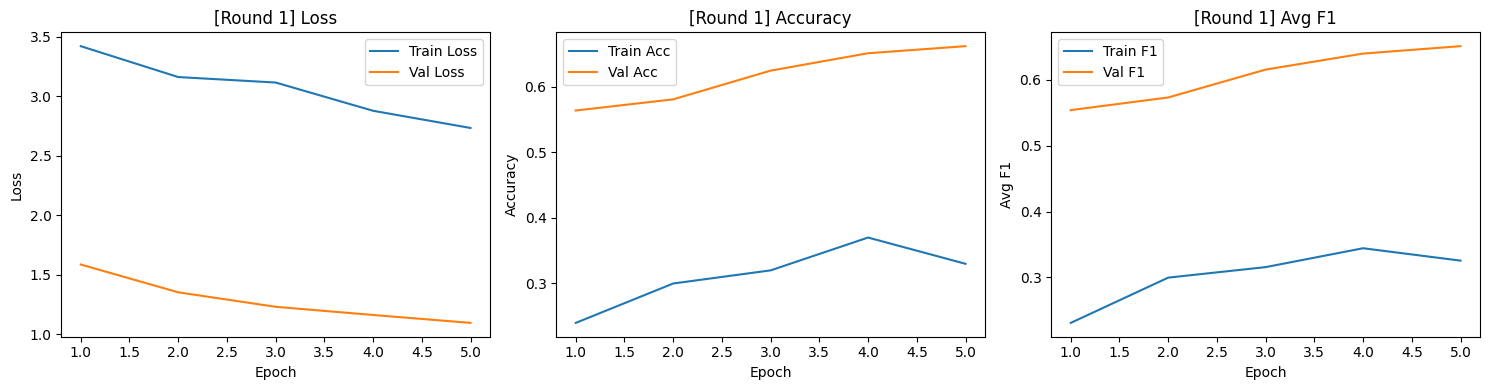


[AL Round 2/20] — Labeled samples: 110



Epoch 5/5
Train — Loss: 1.8494 | Acc: 0.5545 | Avg F1: 0.5473
Val   — Loss: 1.5326 | Acc: 0.6208 | Avg F1: 0.5942


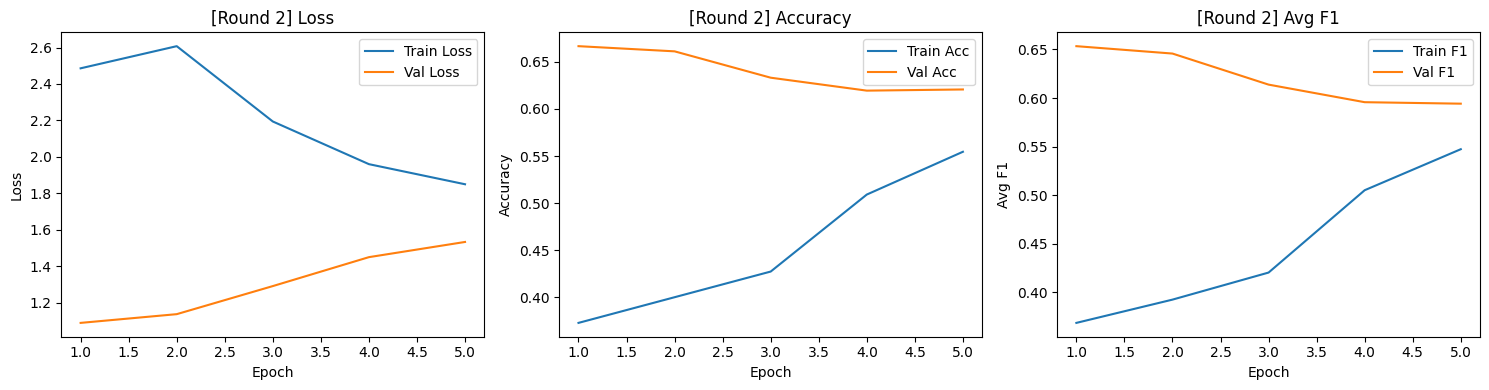


[AL Round 3/20] — Labeled samples: 120



Epoch 5/5
Train — Loss: 1.3240 | Acc: 0.6333 | Avg F1: 0.6160
Val   — Loss: 1.6665 | Acc: 0.6627 | Avg F1: 0.6485



[AL Round 4/20] — Labeled samples: 130



Epoch 5/5
Train — Loss: 1.1612 | Acc: 0.6846 | Avg F1: 0.6620
Val   — Loss: 1.9742 | Acc: 0.5925 | Avg F1: 0.5554



[AL Round 5/20] — Labeled samples: 140



Epoch 10/10
Train — Loss: 0.9725 | Acc: 0.6571 | Avg F1: 0.6547
Val   — Loss: 3.0779 | Acc: 0.4150 | Avg F1: 0.3670



[AL Round 6/20] — Labeled samples: 150



Epoch 10/10
Train — Loss: 0.9097 | Acc: 0.7133 | Avg F1: 0.7121
Val   — Loss: 1.6789 | Acc: 0.5827 | Avg F1: 0.5420


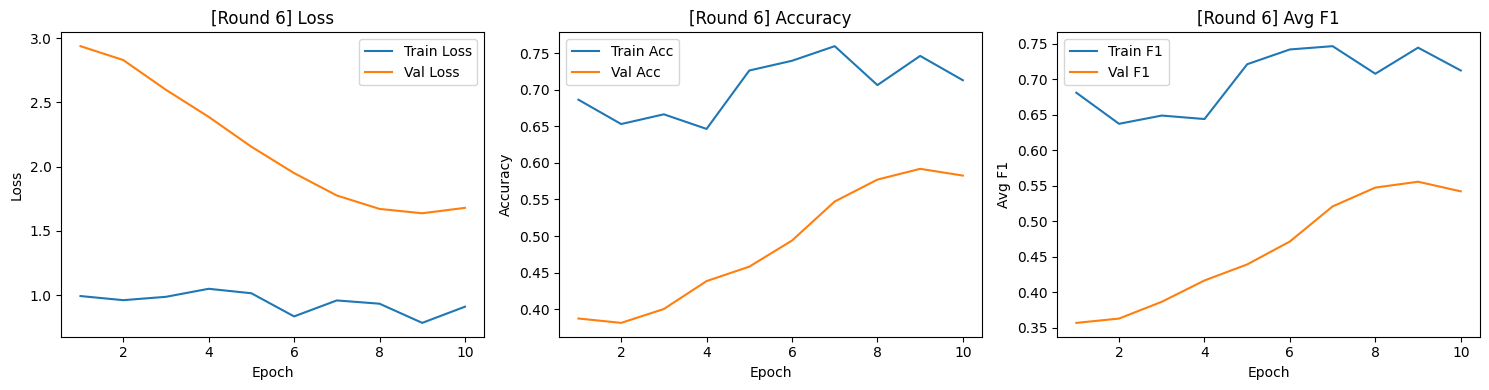


[AL Round 7/20] — Labeled samples: 160



Epoch 10/10
Train — Loss: 0.7876 | Acc: 0.7250 | Avg F1: 0.7303
Val   — Loss: 1.3764 | Acc: 0.6208 | Avg F1: 0.5914


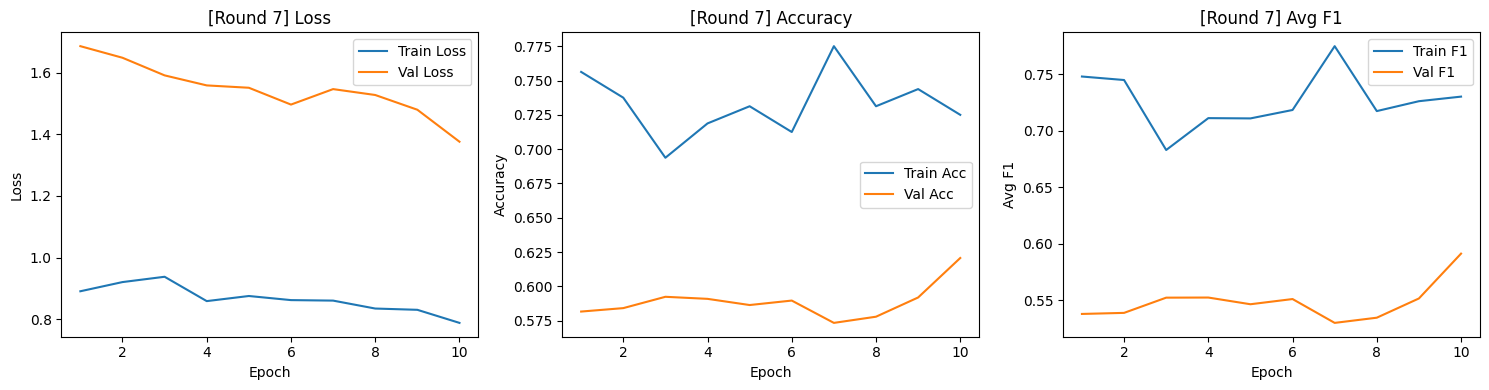


[AL Round 8/20] — Labeled samples: 170



Epoch 10/10
Train — Loss: 0.7807 | Acc: 0.7647 | Avg F1: 0.7656
Val   — Loss: 0.9101 | Acc: 0.7365 | Avg F1: 0.7339


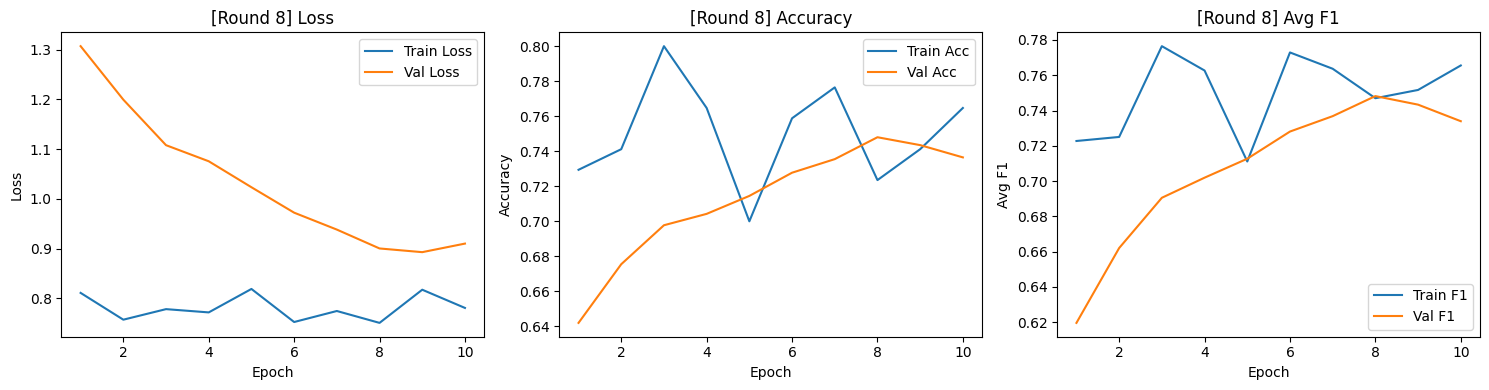


[AL Round 9/20] — Labeled samples: 180



Epoch 10/10
Train — Loss: 0.7132 | Acc: 0.7778 | Avg F1: 0.7702
Val   — Loss: 0.8244 | Acc: 0.7640 | Avg F1: 0.7660


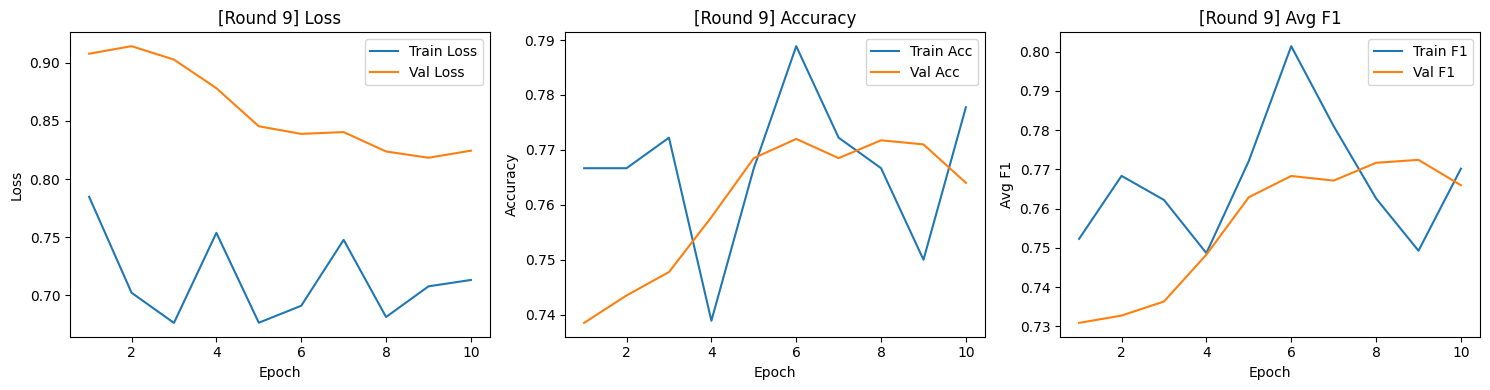


[AL Round 10/20] — Labeled samples: 190



Epoch 10/10
Train — Loss: 0.6420 | Acc: 0.7842 | Avg F1: 0.8028
Val   — Loss: 0.7862 | Acc: 0.7853 | Avg F1: 0.7865


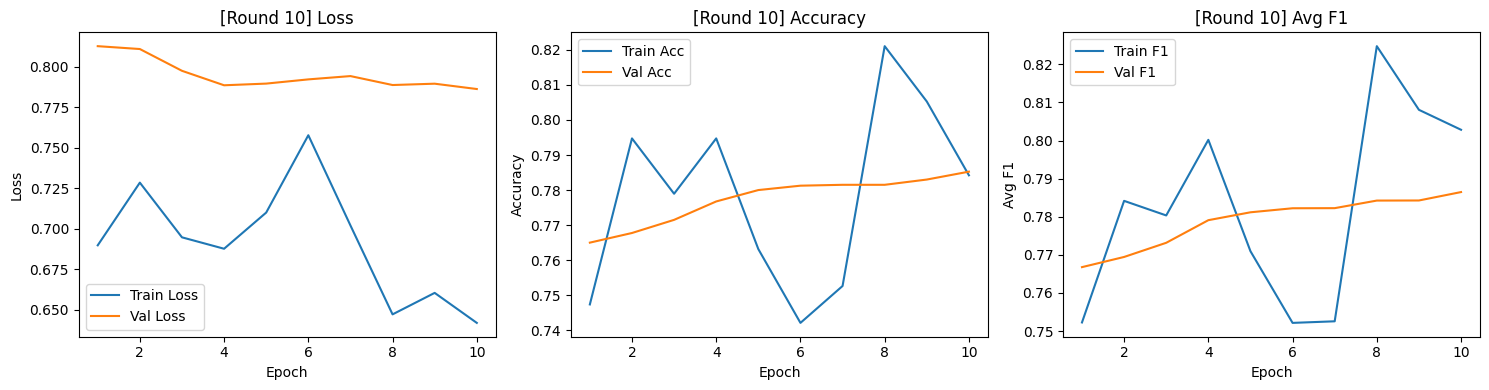


[AL Round 11/20] — Labeled samples: 200



Epoch 10/10
Train — Loss: 0.6069 | Acc: 0.7950 | Avg F1: 0.8133
Val   — Loss: 0.8746 | Acc: 0.7525 | Avg F1: 0.7575


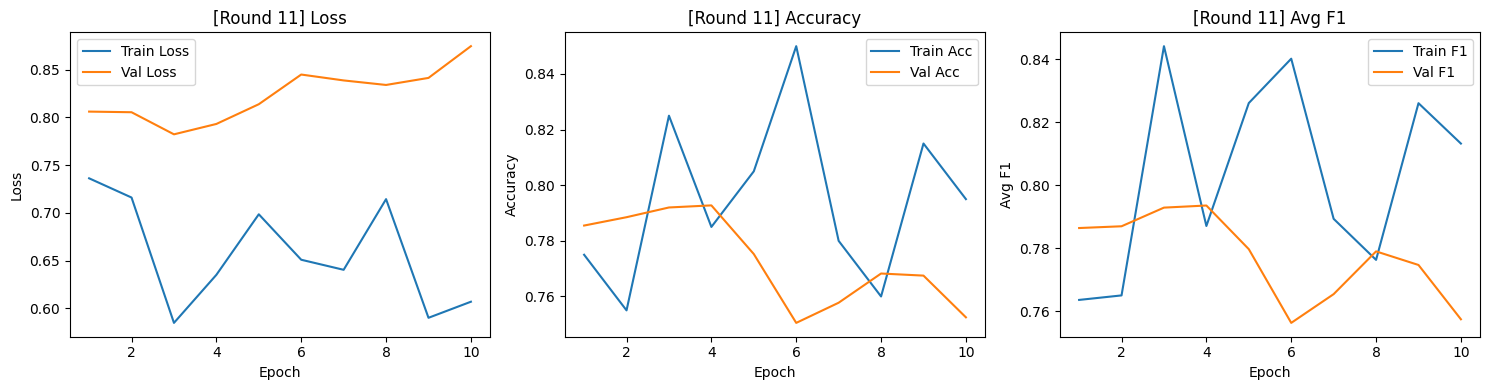


[AL Round 12/20] — Labeled samples: 210



Epoch 15/15
Train — Loss: 0.6140 | Acc: 0.8143 | Avg F1: 0.8276
Val   — Loss: 0.7684 | Acc: 0.7810 | Avg F1: 0.7846


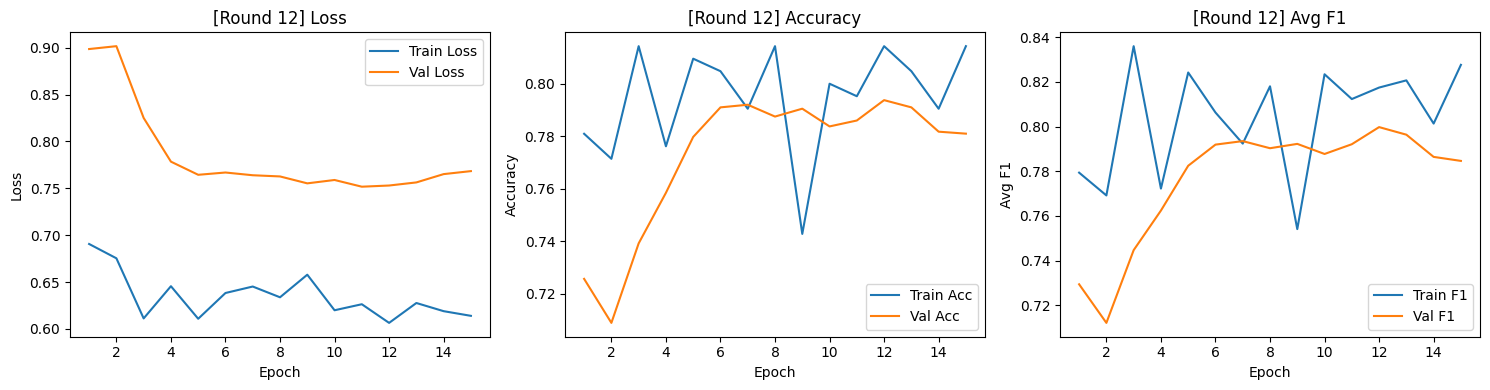


[AL Round 13/20] — Labeled samples: 220



Epoch 15/15
Train — Loss: 0.5868 | Acc: 0.7773 | Avg F1: 0.7963
Val   — Loss: 0.7373 | Acc: 0.7993 | Avg F1: 0.8054


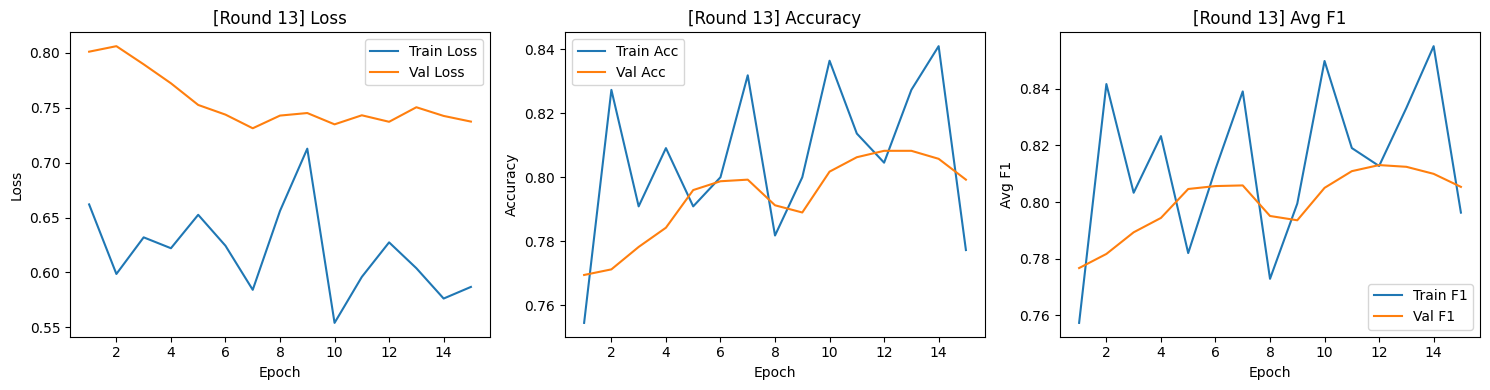


[AL Round 14/20] — Labeled samples: 230



Epoch 15/15
Train — Loss: 0.5622 | Acc: 0.8348 | Avg F1: 0.8482
Val   — Loss: 0.7377 | Acc: 0.8047 | Avg F1: 0.8122



[AL Round 15/20] — Labeled samples: 240



Epoch 15/15
Train — Loss: 0.5611 | Acc: 0.8250 | Avg F1: 0.8290
Val   — Loss: 0.7501 | Acc: 0.8003 | Avg F1: 0.8087



[AL Round 16/20] — Labeled samples: 250



Epoch 15/15
Train — Loss: 0.6200 | Acc: 0.7880 | Avg F1: 0.8020
Val   — Loss: 0.7517 | Acc: 0.7837 | Avg F1: 0.7901


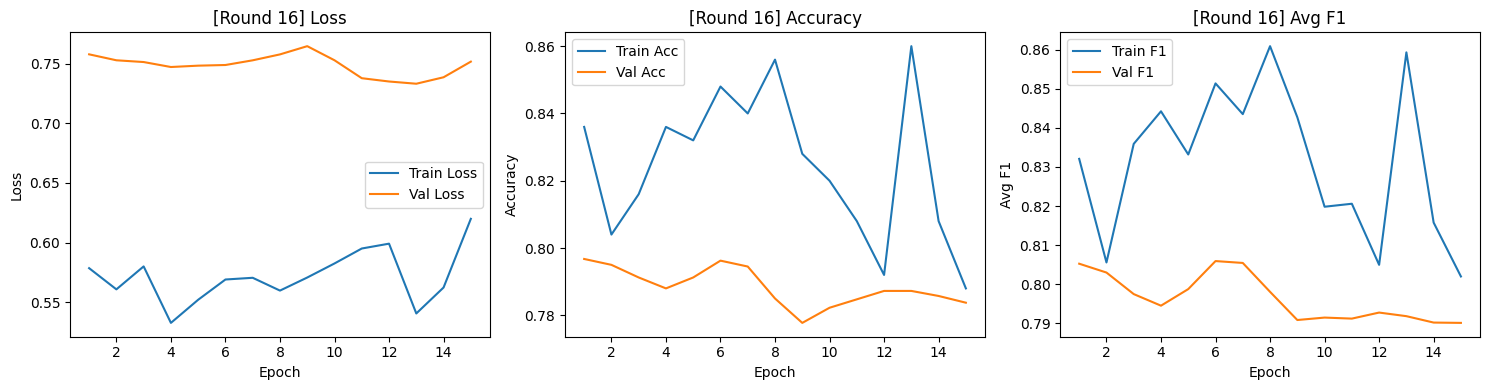


[AL Round 17/20] — Labeled samples: 260



Epoch 15/15
Train — Loss: 0.5847 | Acc: 0.8308 | Avg F1: 0.8302
Val   — Loss: 0.8477 | Acc: 0.7925 | Avg F1: 0.8030


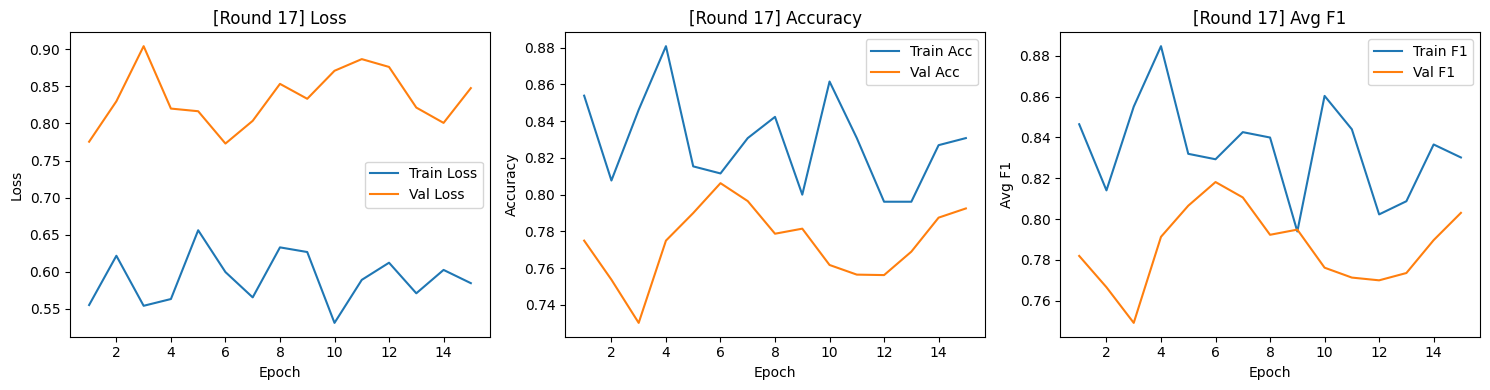


[AL Round 18/20] — Labeled samples: 270



Epoch 15/15
Train — Loss: 0.6022 | Acc: 0.8148 | Avg F1: 0.8214
Val   — Loss: 0.7560 | Acc: 0.7658 | Avg F1: 0.7773


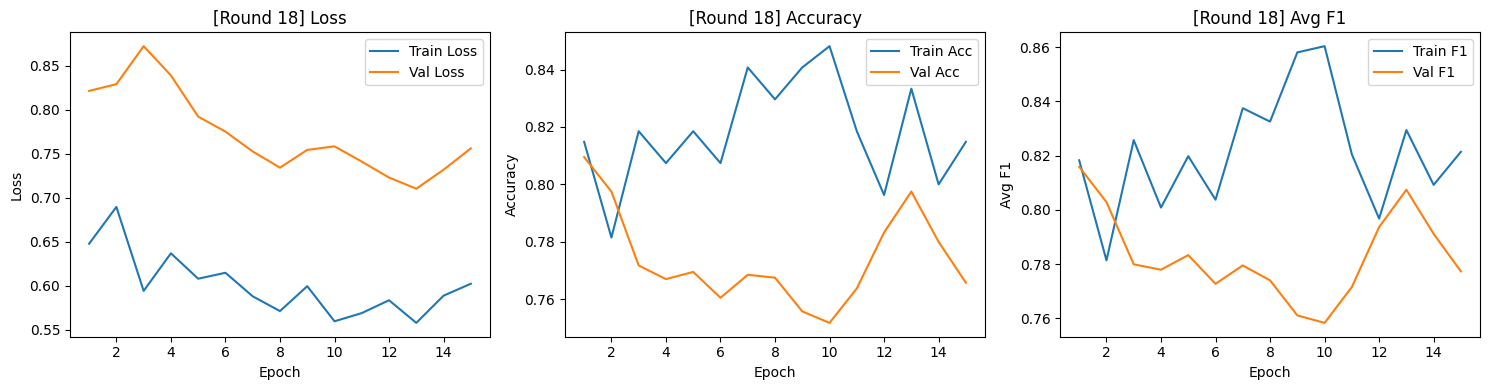


[AL Round 19/20] — Labeled samples: 280



Epoch 15/15
Train — Loss: 0.5718 | Acc: 0.8571 | Avg F1: 0.8554
Val   — Loss: 0.7230 | Acc: 0.7810 | Avg F1: 0.7854


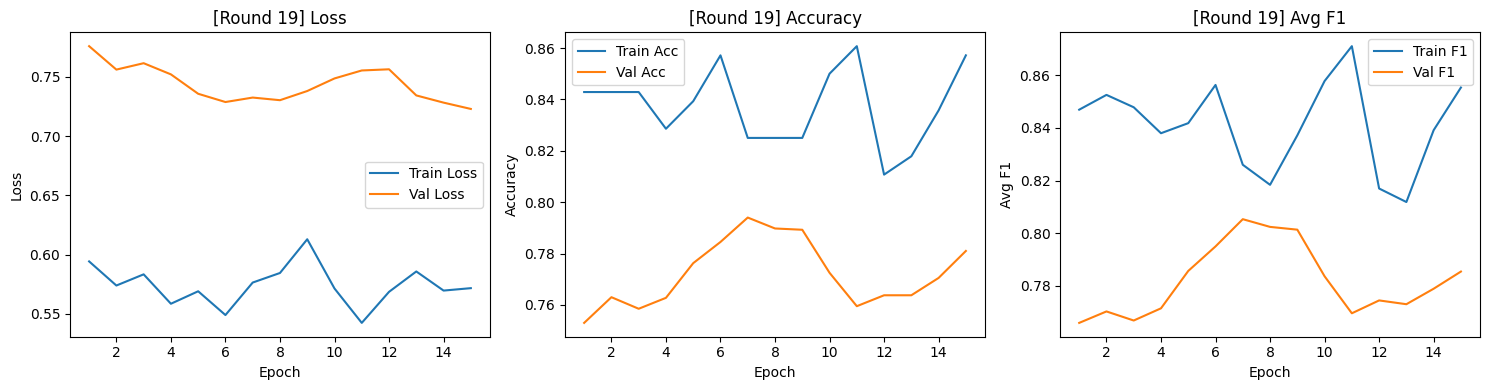


[AL Round 20/20] — Labeled samples: 290



Epoch 15/15
Train — Loss: 0.5367 | Acc: 0.8379 | Avg F1: 0.8437
Val   — Loss: 0.7167 | Acc: 0.7875 | Avg F1: 0.7944


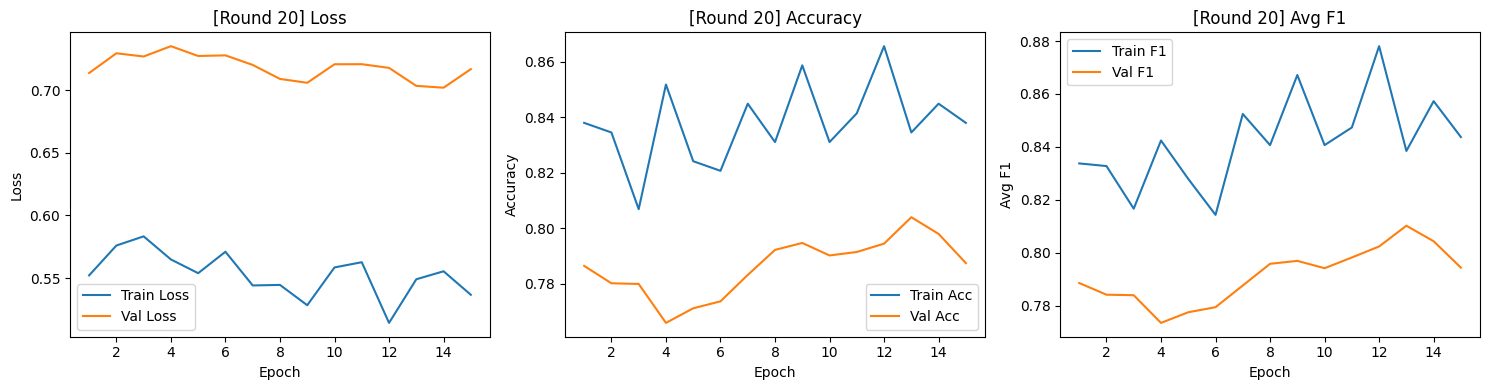


=== Running strategy: ENTROPY ===

[AL Round 1/20] — Labeled samples: 100



Epoch 5/5
Train — Loss: 2.7328 | Acc: 0.2800 | Avg F1: 0.2695
Val   — Loss: 1.2343 | Acc: 0.6228 | Avg F1: 0.6025


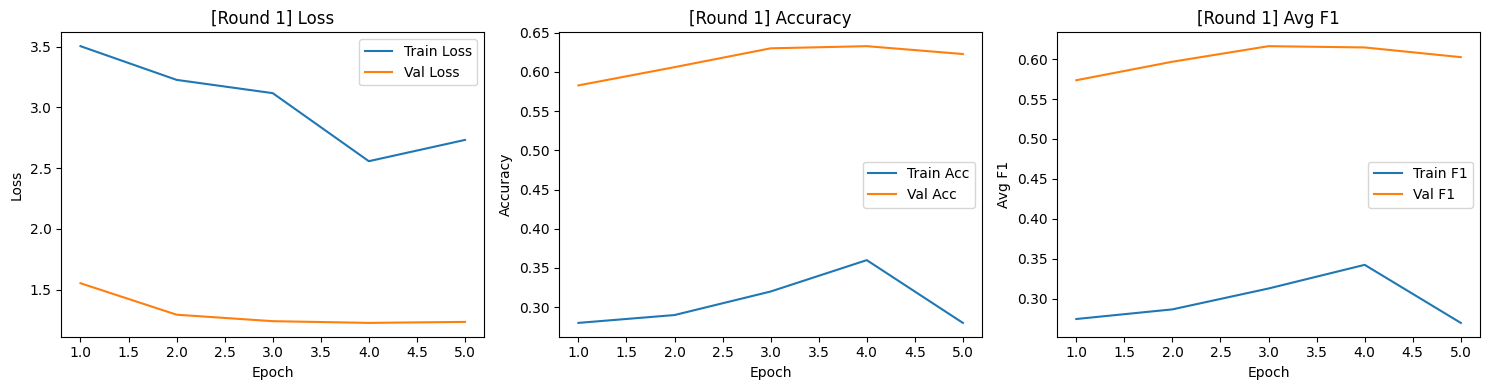


[AL Round 2/20] — Labeled samples: 110



Epoch 5/5
Train — Loss: 1.9278 | Acc: 0.5000 | Avg F1: 0.4859
Val   — Loss: 1.7942 | Acc: 0.5617 | Avg F1: 0.5486


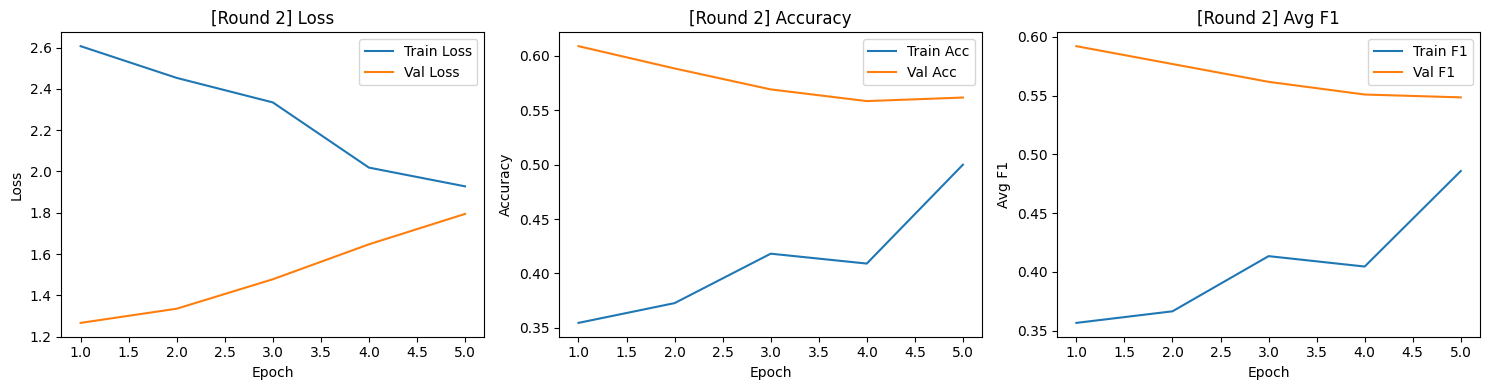


[AL Round 3/20] — Labeled samples: 120



Epoch 5/5
Train — Loss: 1.5640 | Acc: 0.5333 | Avg F1: 0.5164
Val   — Loss: 3.0478 | Acc: 0.5553 | Avg F1: 0.5023


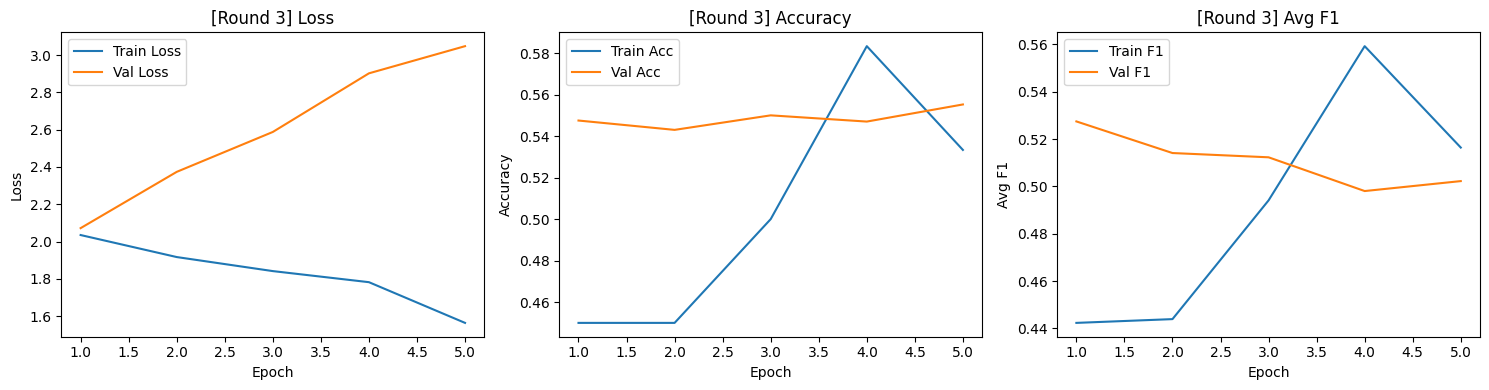


[AL Round 4/20] — Labeled samples: 130



Epoch 5/5
Train — Loss: 1.2053 | Acc: 0.6615 | Avg F1: 0.6167
Val   — Loss: 2.2862 | Acc: 0.7210 | Avg F1: 0.6984


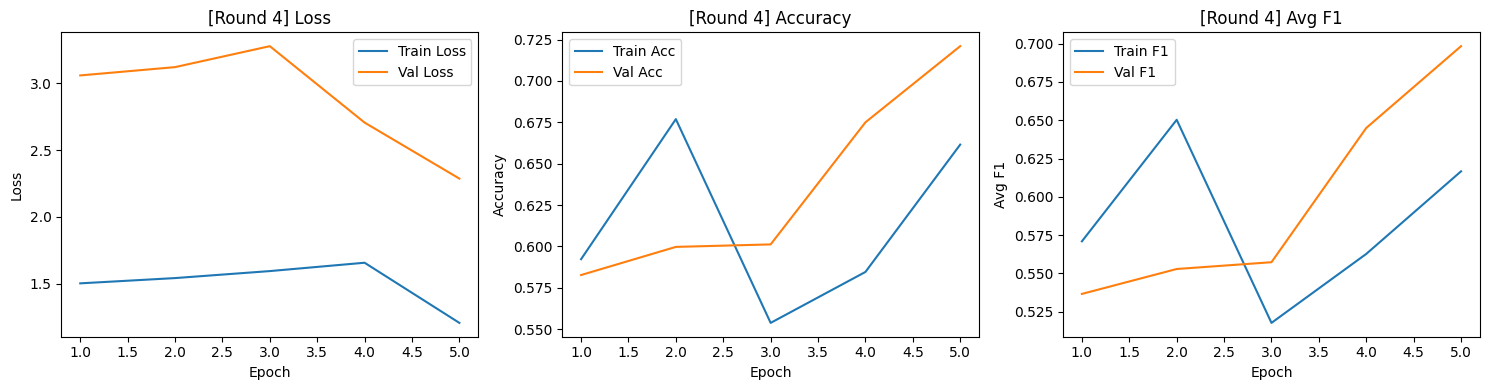


[AL Round 5/20] — Labeled samples: 140



Epoch 10/10
Train — Loss: 1.1566 | Acc: 0.6500 | Avg F1: 0.6262
Val   — Loss: 1.7838 | Acc: 0.7555 | Avg F1: 0.7409



[AL Round 6/20] — Labeled samples: 150



Epoch 10/10
Train — Loss: 1.0279 | Acc: 0.7200 | Avg F1: 0.7020
Val   — Loss: 1.7069 | Acc: 0.7302 | Avg F1: 0.7130



[AL Round 7/20] — Labeled samples: 160



Epoch 10/10
Train — Loss: 1.0148 | Acc: 0.6500 | Avg F1: 0.6175
Val   — Loss: 1.4937 | Acc: 0.7555 | Avg F1: 0.7413


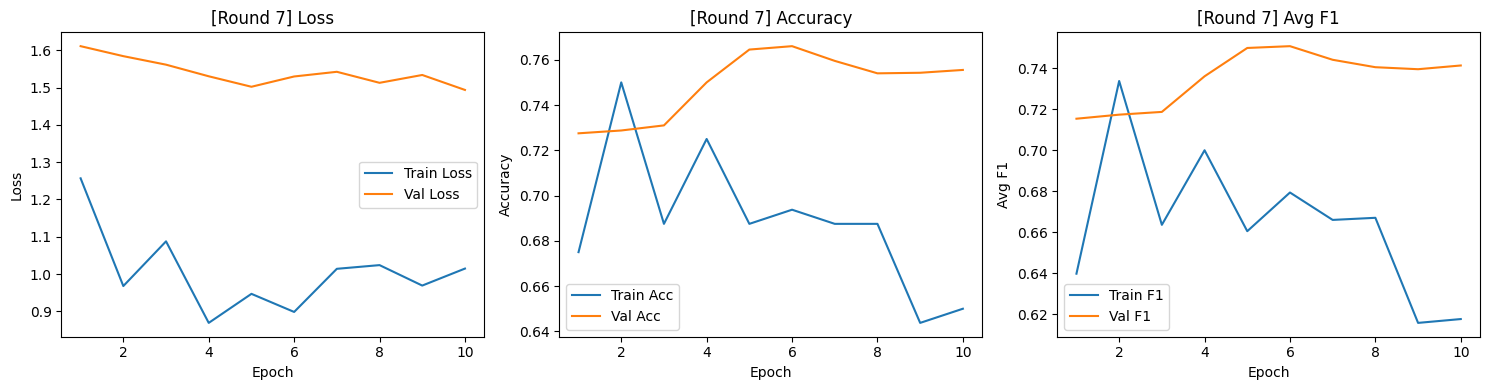


[AL Round 8/20] — Labeled samples: 170



Epoch 10/10
Train — Loss: 0.8573 | Acc: 0.7647 | Avg F1: 0.7597
Val   — Loss: 1.5093 | Acc: 0.7438 | Avg F1: 0.7303


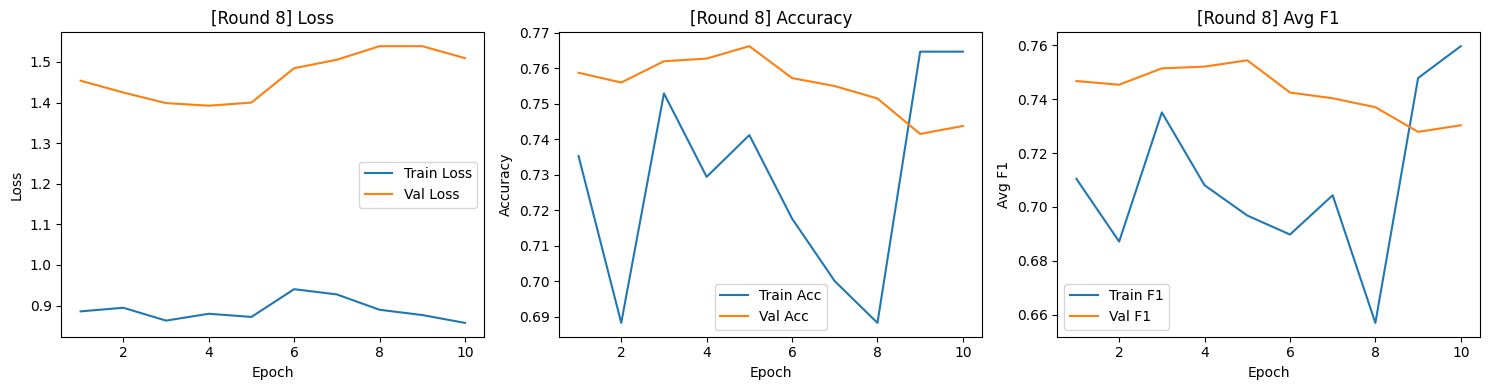


[AL Round 9/20] — Labeled samples: 180



Epoch 10/10
Train — Loss: 0.9405 | Acc: 0.7222 | Avg F1: 0.7251
Val   — Loss: 1.3624 | Acc: 0.7655 | Avg F1: 0.7485



[AL Round 10/20] — Labeled samples: 190



Epoch 10/10
Train — Loss: 0.7980 | Acc: 0.7053 | Avg F1: 0.7224
Val   — Loss: 1.3405 | Acc: 0.7360 | Avg F1: 0.7221


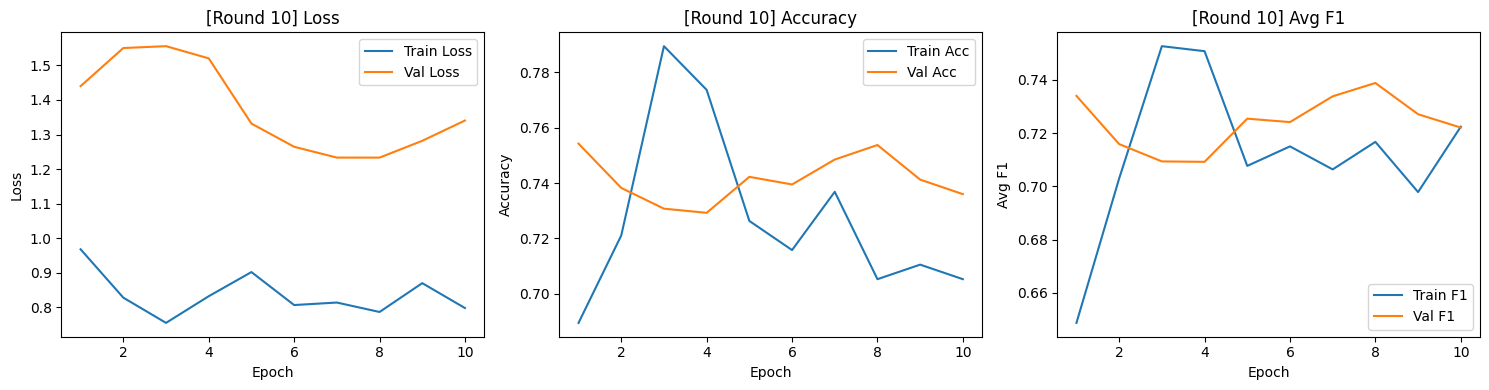


[AL Round 11/20] — Labeled samples: 200



Epoch 10/10
Train — Loss: 0.7034 | Acc: 0.8050 | Avg F1: 0.8100
Val   — Loss: 1.4269 | Acc: 0.6860 | Avg F1: 0.6764



[AL Round 12/20] — Labeled samples: 210



Epoch 15/15
Train — Loss: 0.7665 | Acc: 0.7286 | Avg F1: 0.7159
Val   — Loss: 1.2242 | Acc: 0.7113 | Avg F1: 0.6999



[AL Round 13/20] — Labeled samples: 220



Epoch 15/15
Train — Loss: 0.6130 | Acc: 0.7773 | Avg F1: 0.7681
Val   — Loss: 1.0748 | Acc: 0.7252 | Avg F1: 0.7196


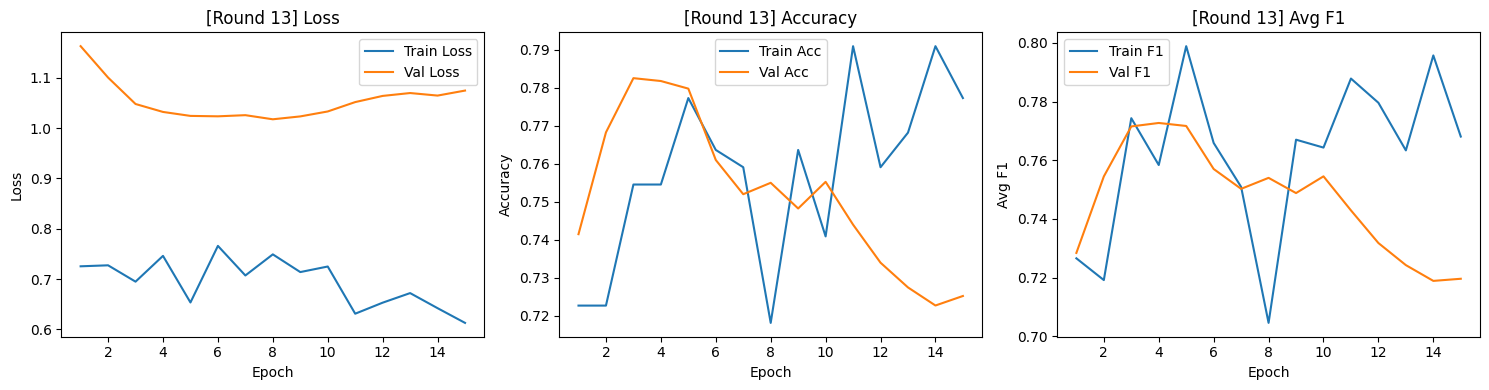


[AL Round 14/20] — Labeled samples: 230



Epoch 15/15
Train — Loss: 0.6609 | Acc: 0.7696 | Avg F1: 0.7725
Val   — Loss: 1.0179 | Acc: 0.7412 | Avg F1: 0.7369


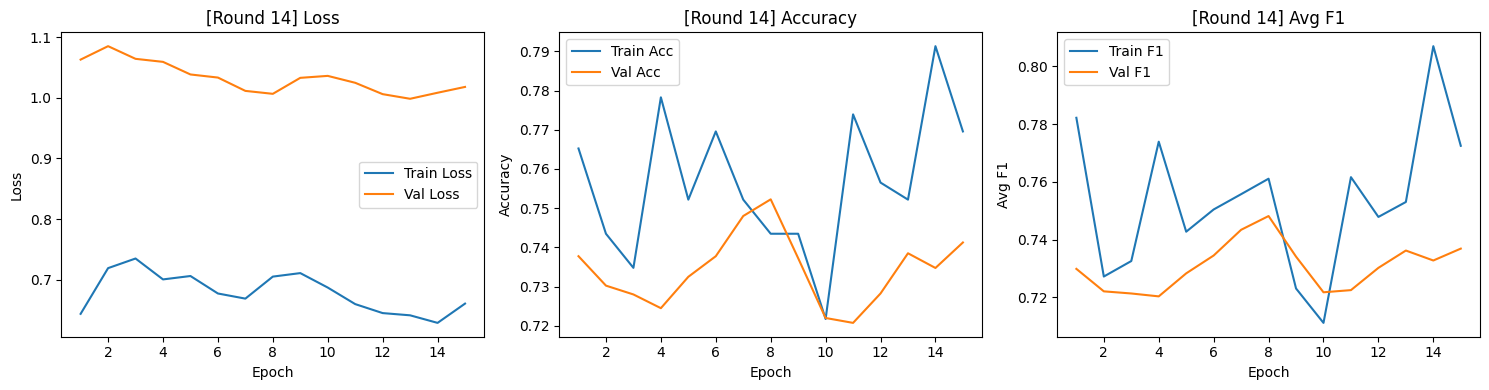


[AL Round 15/20] — Labeled samples: 240



Epoch 15/15
Train — Loss: 0.6638 | Acc: 0.7542 | Avg F1: 0.7423
Val   — Loss: 0.9413 | Acc: 0.7542 | Avg F1: 0.7507


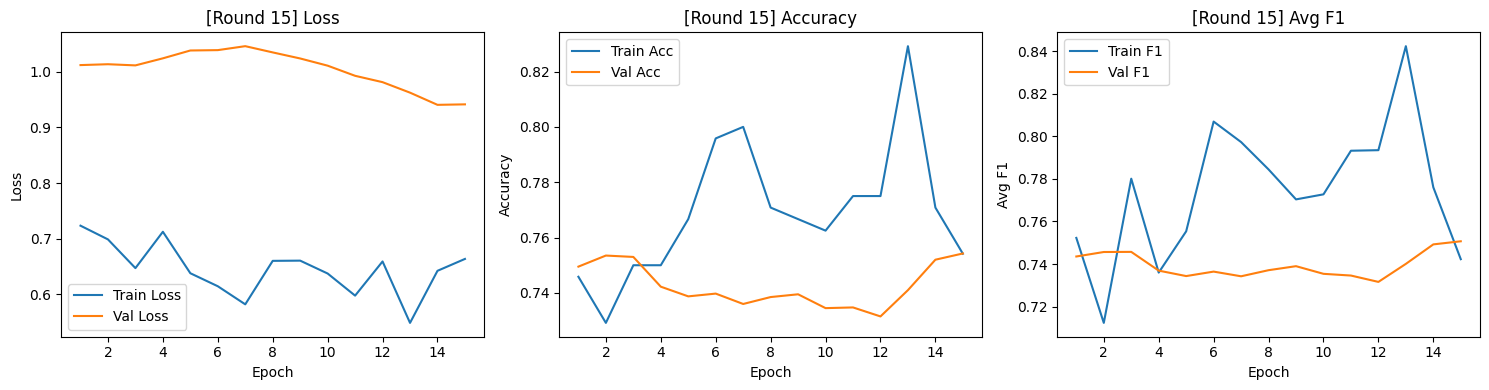


[AL Round 16/20] — Labeled samples: 250



Epoch 15/15
Train — Loss: 0.6146 | Acc: 0.7760 | Avg F1: 0.7671
Val   — Loss: 0.9395 | Acc: 0.7580 | Avg F1: 0.7544


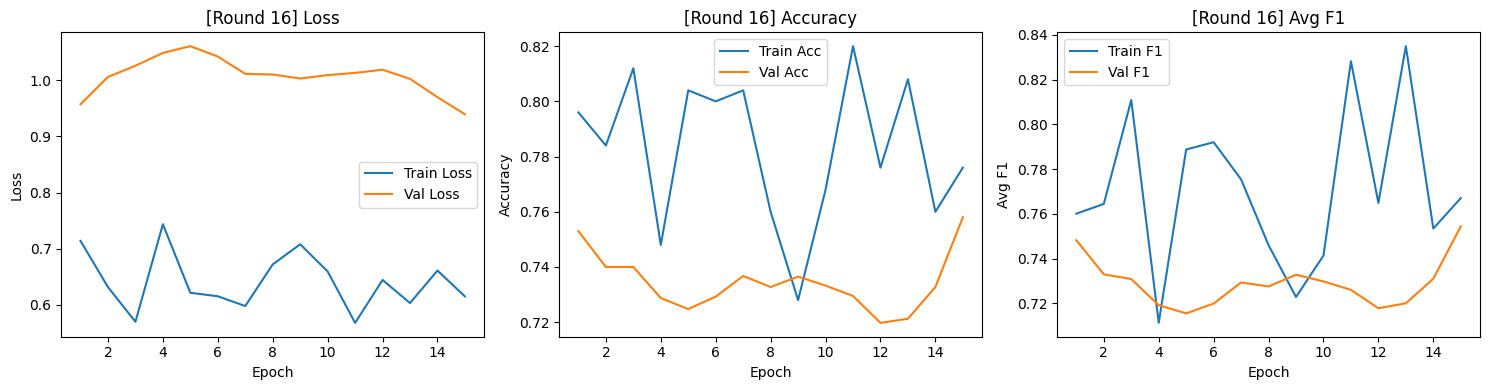


[AL Round 17/20] — Labeled samples: 260



Epoch 15/15
Train — Loss: 0.7592 | Acc: 0.7346 | Avg F1: 0.7119
Val   — Loss: 1.2427 | Acc: 0.6188 | Avg F1: 0.6119


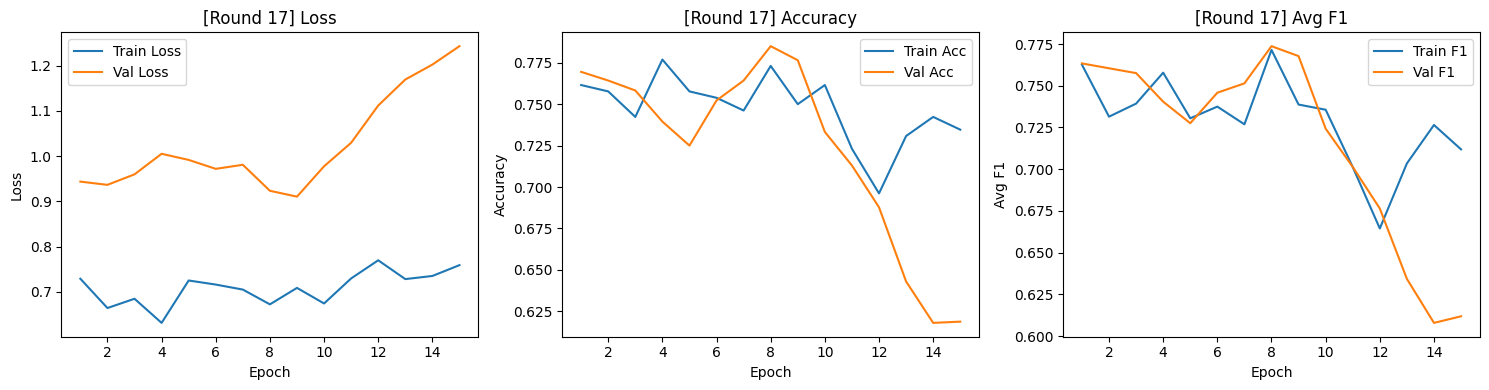


[AL Round 18/20] — Labeled samples: 270



Epoch 15/15
Train — Loss: 0.6774 | Acc: 0.7370 | Avg F1: 0.7155
Val   — Loss: 0.9320 | Acc: 0.7495 | Avg F1: 0.7395


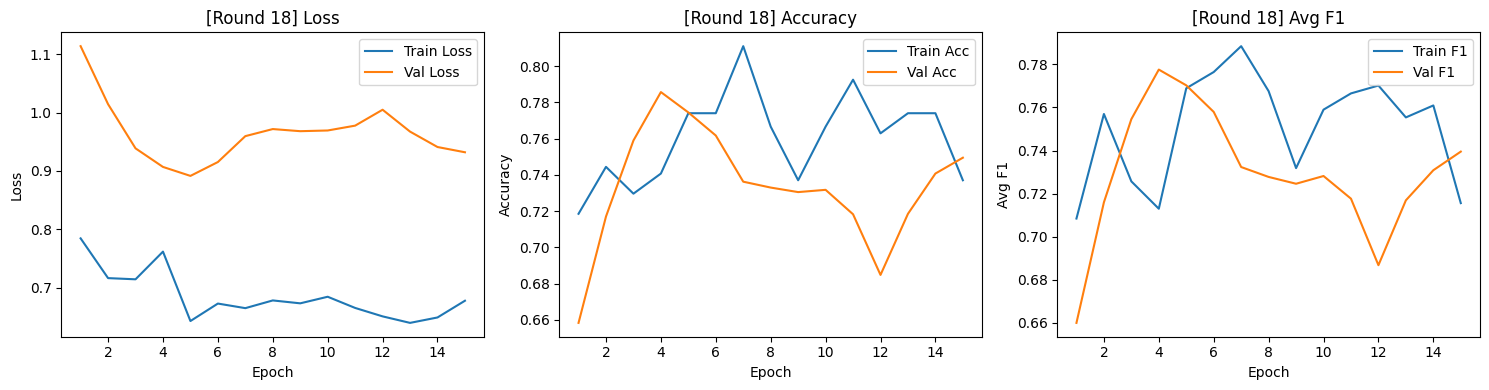


[AL Round 19/20] — Labeled samples: 280



Epoch 15/15
Train — Loss: 0.6354 | Acc: 0.7786 | Avg F1: 0.7612
Val   — Loss: 0.8666 | Acc: 0.7638 | Avg F1: 0.7602


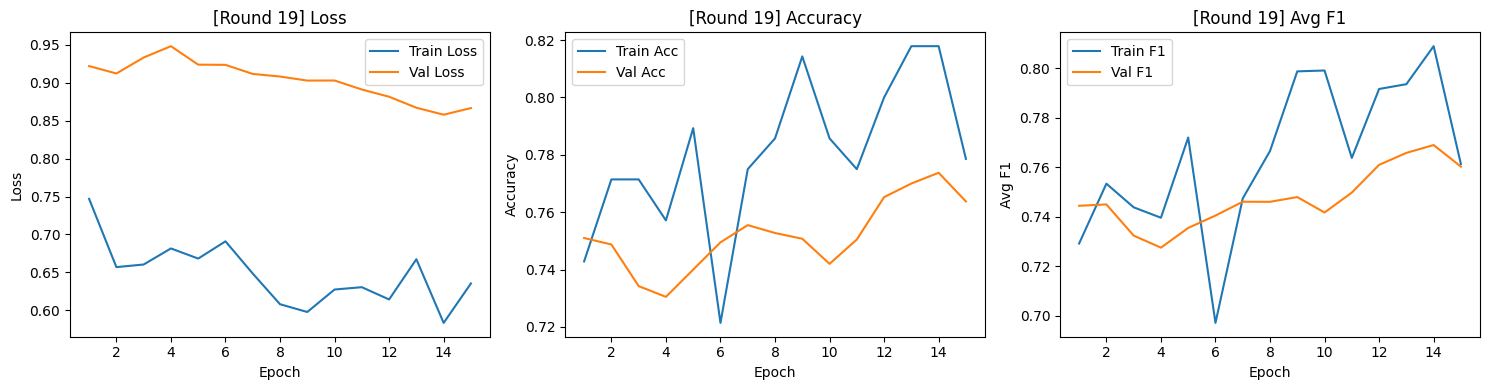


[AL Round 20/20] — Labeled samples: 290



Epoch 15/15
Train — Loss: 0.6082 | Acc: 0.7862 | Avg F1: 0.8007
Val   — Loss: 0.9067 | Acc: 0.7425 | Avg F1: 0.7452


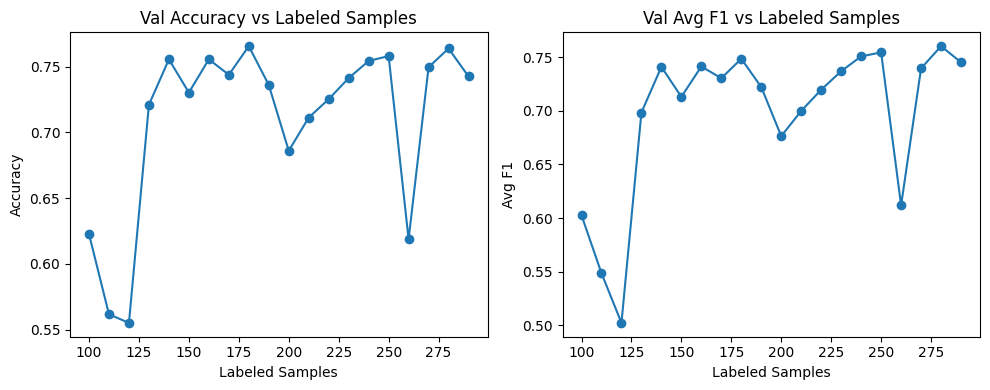


=== Running strategy: ENTROPY_DIVERSITY ===

[AL Round 1/20] — Labeled samples: 100



Epoch 5/5
Train — Loss: 2.7356 | Acc: 0.3000 | Avg F1: 0.2881
Val   — Loss: 1.0814 | Acc: 0.6695 | Avg F1: 0.6572


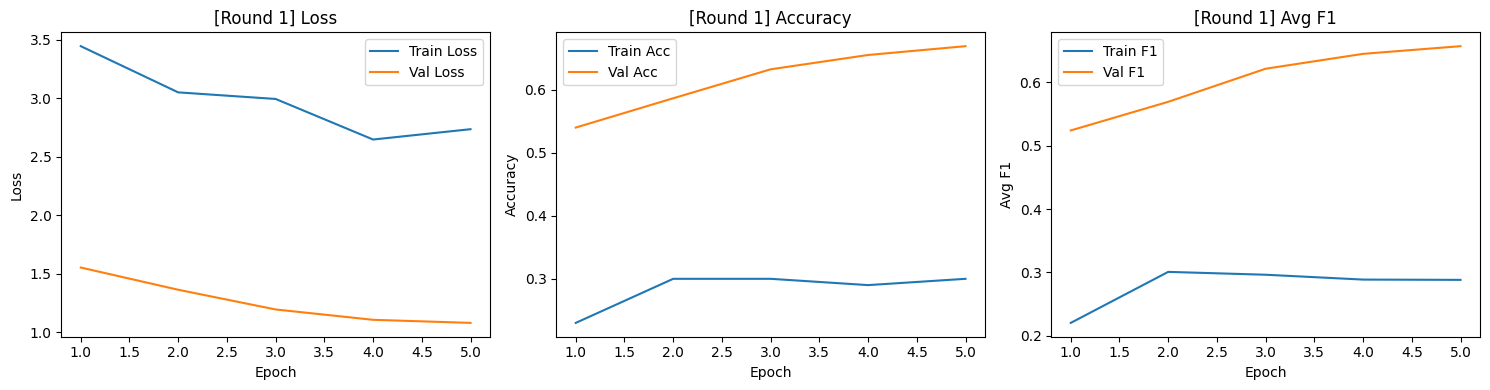


[AL Round 2/20] — Labeled samples: 110



Epoch 5/5
Train — Loss: 2.5310 | Acc: 0.4818 | Avg F1: 0.4738
Val   — Loss: 1.8182 | Acc: 0.6022 | Avg F1: 0.5698


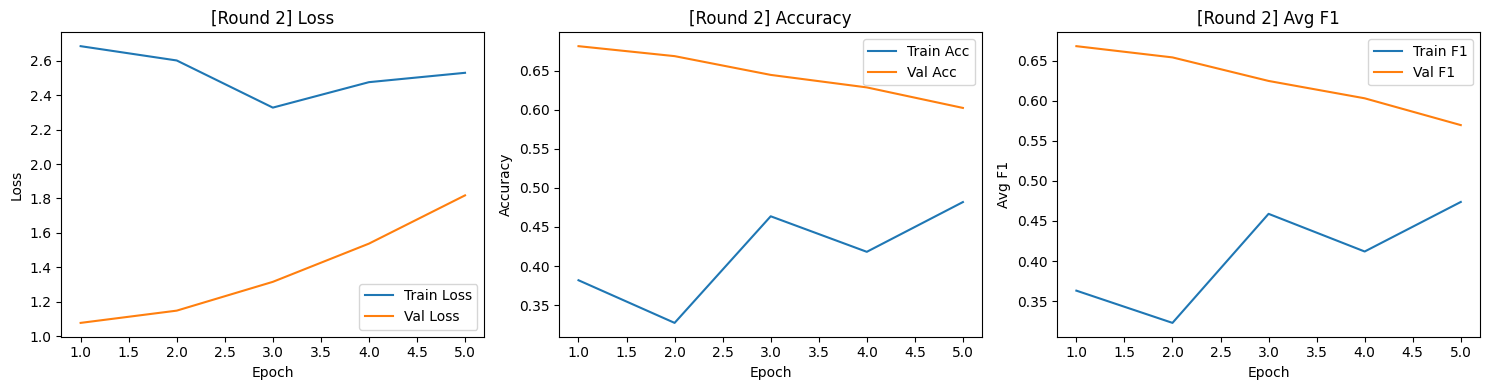


[AL Round 3/20] — Labeled samples: 120



Epoch 5/5
Train — Loss: 1.7454 | Acc: 0.5417 | Avg F1: 0.5249
Val   — Loss: 3.0443 | Acc: 0.4863 | Avg F1: 0.4463


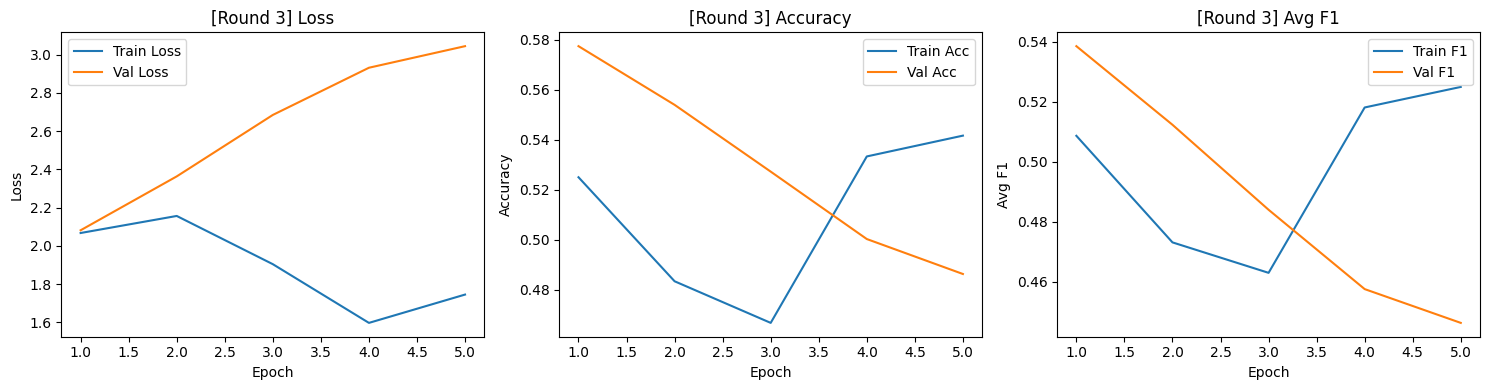


[AL Round 4/20] — Labeled samples: 130



Epoch 5/5
Train — Loss: 1.5531 | Acc: 0.6308 | Avg F1: 0.6065
Val   — Loss: 5.1532 | Acc: 0.2905 | Avg F1: 0.2864



[AL Round 5/20] — Labeled samples: 140



Epoch 10/10
Train — Loss: 1.2800 | Acc: 0.6786 | Avg F1: 0.6467
Val   — Loss: 1.9139 | Acc: 0.7127 | Avg F1: 0.6953


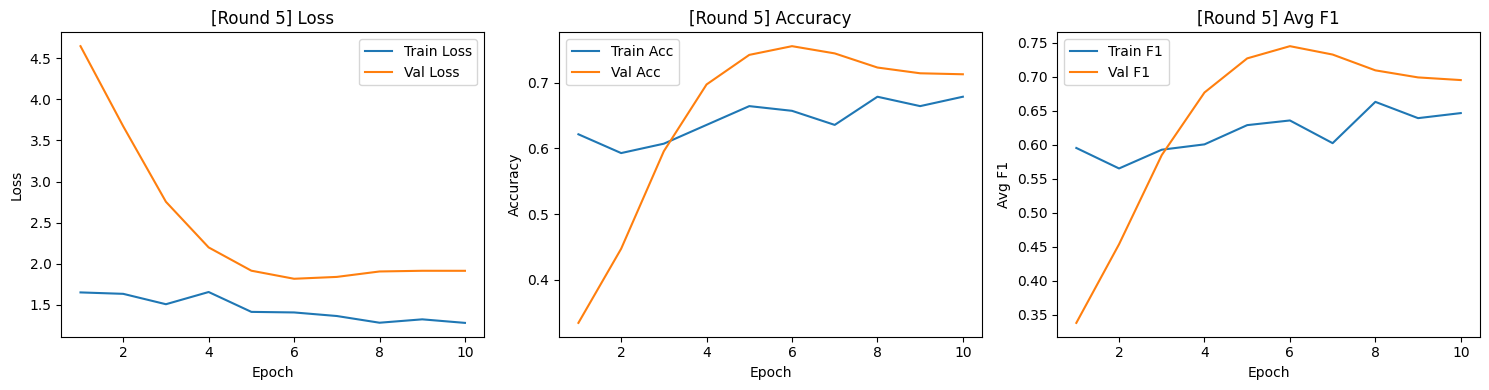


[AL Round 6/20] — Labeled samples: 150



Epoch 10/10
Train — Loss: 1.2920 | Acc: 0.6267 | Avg F1: 0.6105
Val   — Loss: 1.8123 | Acc: 0.7402 | Avg F1: 0.7184


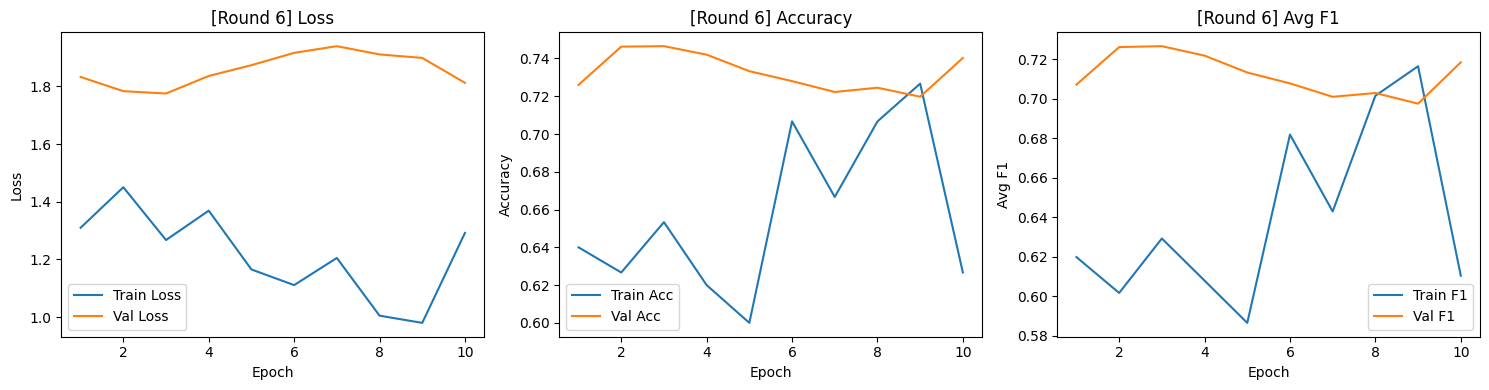


[AL Round 7/20] — Labeled samples: 160



Epoch 10/10
Train — Loss: 1.1141 | Acc: 0.6500 | Avg F1: 0.6572
Val   — Loss: 1.2761 | Acc: 0.7835 | Avg F1: 0.7752


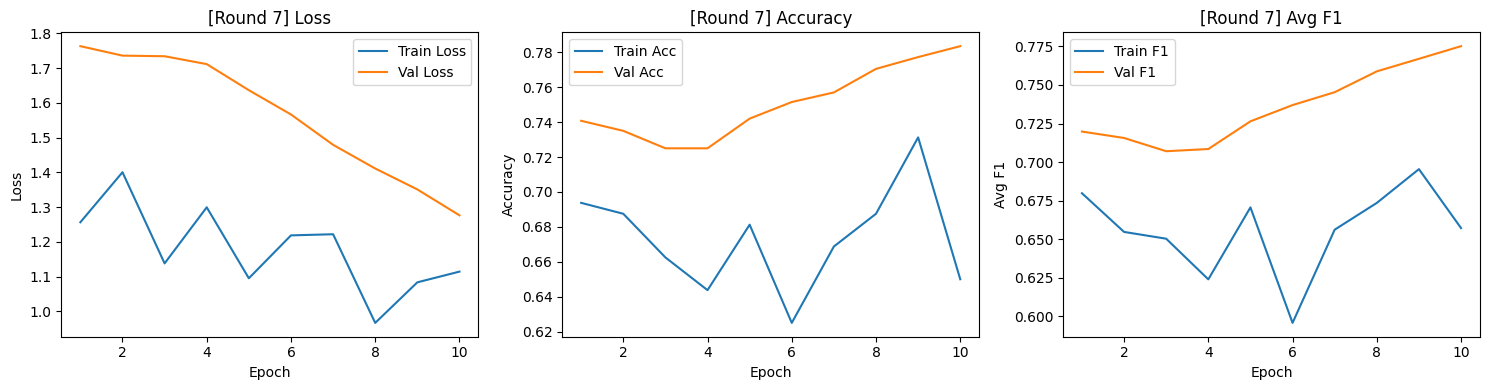


[AL Round 8/20] — Labeled samples: 170



Epoch 10/10
Train — Loss: 1.0026 | Acc: 0.7588 | Avg F1: 0.7591
Val   — Loss: 1.2755 | Acc: 0.7688 | Avg F1: 0.7579



[AL Round 9/20] — Labeled samples: 180



Epoch 10/10
Train — Loss: 0.8349 | Acc: 0.7278 | Avg F1: 0.7081
Val   — Loss: 1.2006 | Acc: 0.7875 | Avg F1: 0.7743


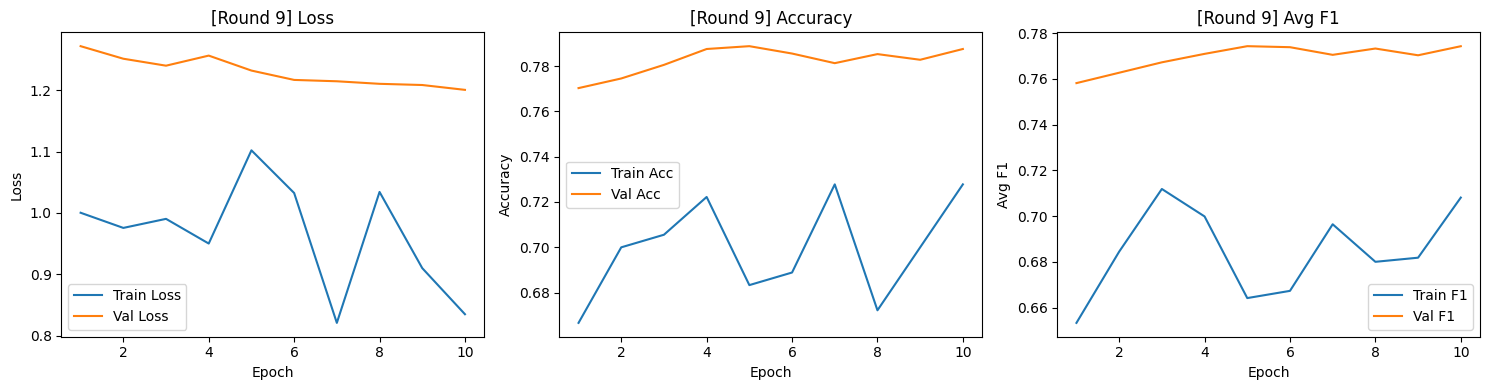


[AL Round 10/20] — Labeled samples: 190



Epoch 10/10
Train — Loss: 0.8929 | Acc: 0.7105 | Avg F1: 0.6849
Val   — Loss: 1.1704 | Acc: 0.7880 | Avg F1: 0.7722


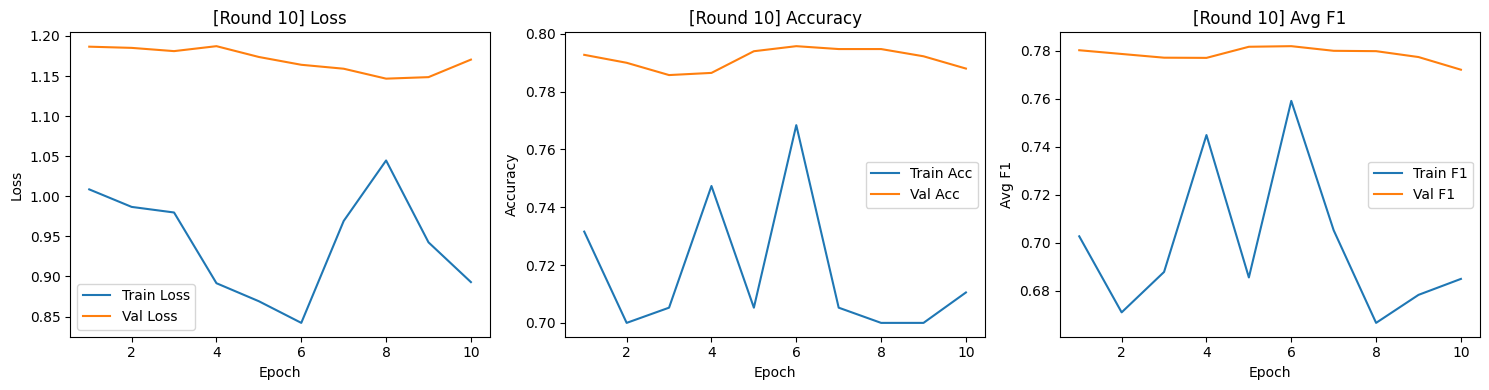


[AL Round 11/20] — Labeled samples: 200



Epoch 10/10
Train — Loss: 0.8256 | Acc: 0.7650 | Avg F1: 0.7426
Val   — Loss: 1.1261 | Acc: 0.7857 | Avg F1: 0.7704


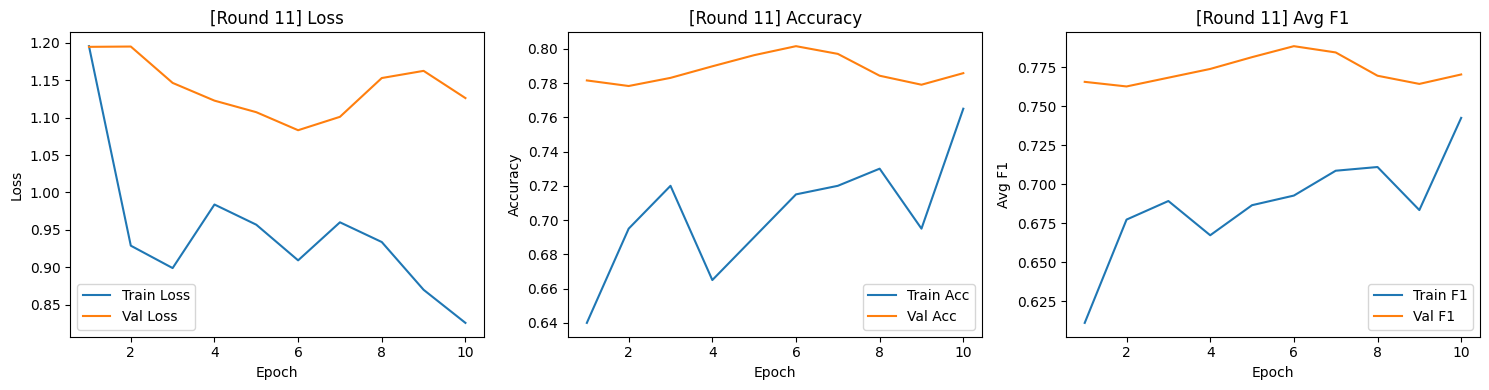


[AL Round 12/20] — Labeled samples: 210



Epoch 15/15
Train — Loss: 0.8561 | Acc: 0.6952 | Avg F1: 0.7081
Val   — Loss: 1.0619 | Acc: 0.7907 | Avg F1: 0.7742



[AL Round 13/20] — Labeled samples: 220



Epoch 15/15
Train — Loss: 0.7654 | Acc: 0.7409 | Avg F1: 0.7468
Val   — Loss: 0.9824 | Acc: 0.7967 | Avg F1: 0.7821


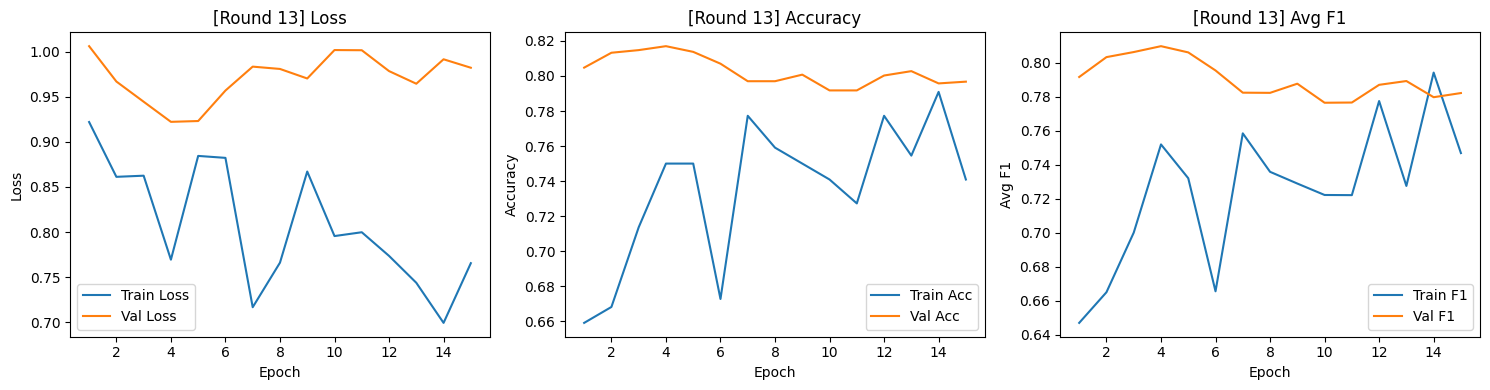


[AL Round 14/20] — Labeled samples: 230



Epoch 15/15
Train — Loss: 0.8019 | Acc: 0.7304 | Avg F1: 0.7205
Val   — Loss: 0.9295 | Acc: 0.8065 | Avg F1: 0.7951


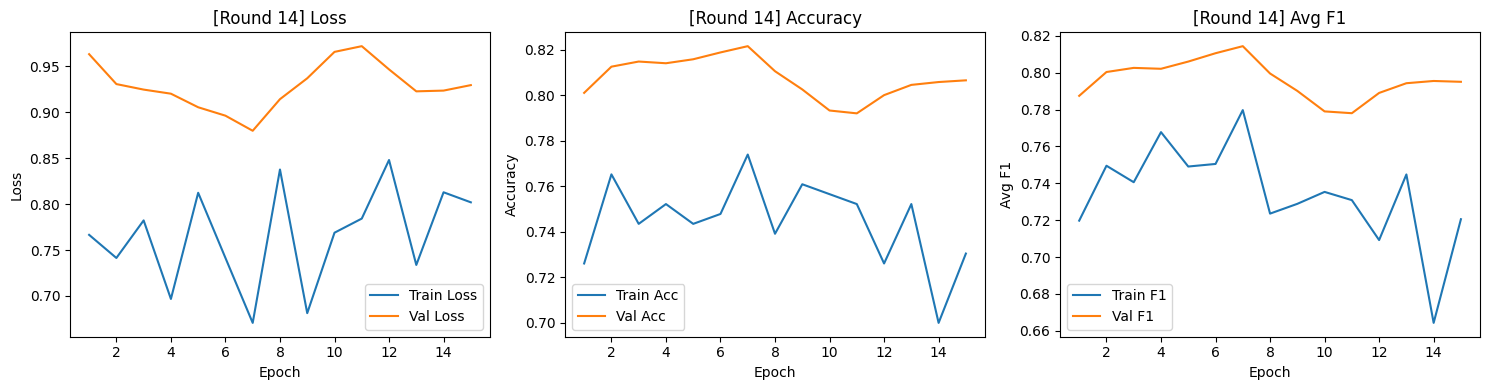


[AL Round 15/20] — Labeled samples: 240



Epoch 15/15
Train — Loss: 0.7381 | Acc: 0.7667 | Avg F1: 0.7579
Val   — Loss: 0.9153 | Acc: 0.8230 | Avg F1: 0.8104


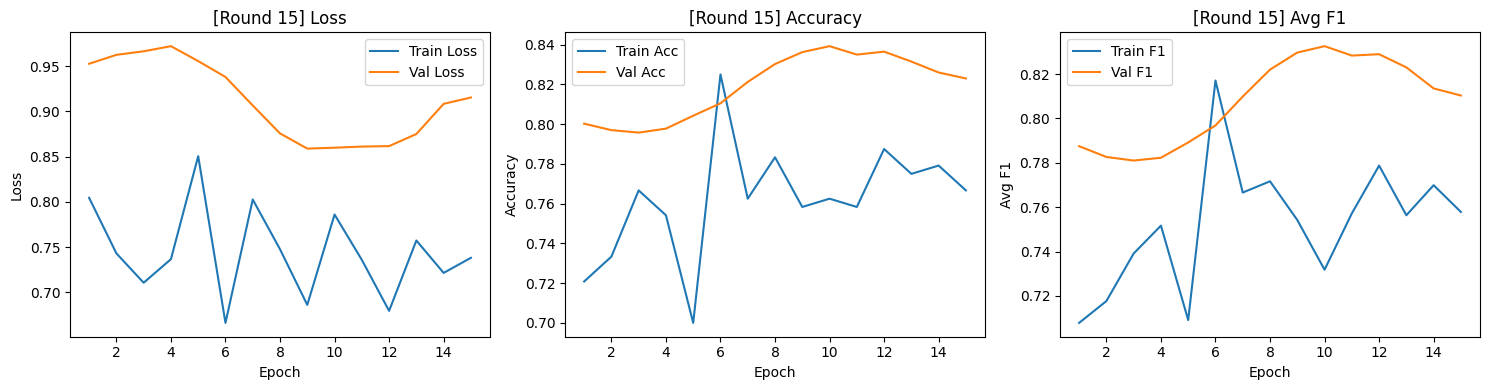


[AL Round 16/20] — Labeled samples: 250



Epoch 15/15
Train — Loss: 0.7205 | Acc: 0.7720 | Avg F1: 0.7621
Val   — Loss: 0.8418 | Acc: 0.8297 | Avg F1: 0.8199



[AL Round 17/20] — Labeled samples: 260



Epoch 15/15
Train — Loss: 0.7167 | Acc: 0.7385 | Avg F1: 0.7284
Val   — Loss: 0.8502 | Acc: 0.8297 | Avg F1: 0.8272



[AL Round 18/20] — Labeled samples: 270



Epoch 15/15
Train — Loss: 0.6509 | Acc: 0.7667 | Avg F1: 0.7602
Val   — Loss: 0.8190 | Acc: 0.8210 | Avg F1: 0.8232



[AL Round 19/20] — Labeled samples: 280



Epoch 15/15
Train — Loss: 0.6943 | Acc: 0.7714 | Avg F1: 0.7508
Val   — Loss: 0.8072 | Acc: 0.8315 | Avg F1: 0.8271


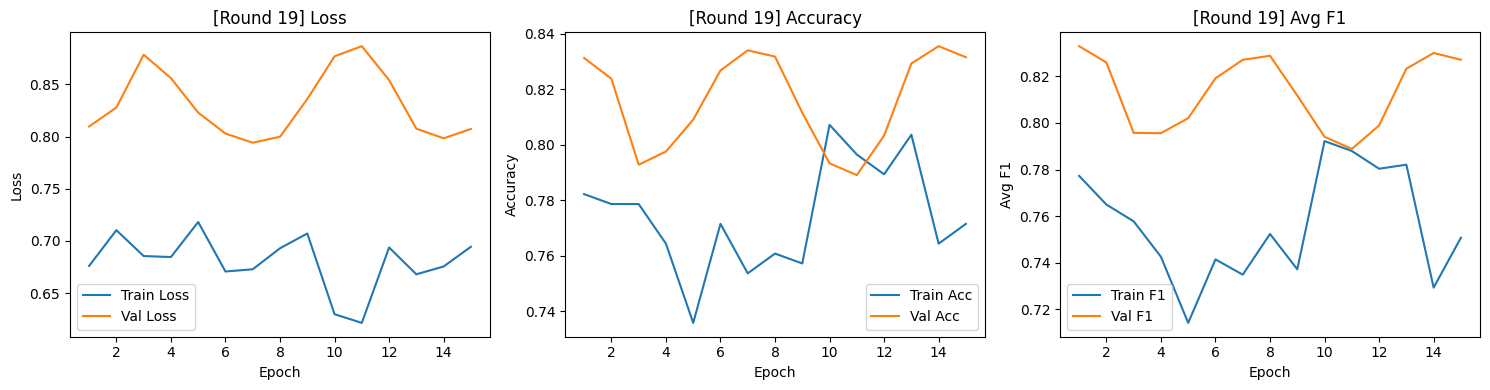


[AL Round 20/20] — Labeled samples: 290



Epoch 15/15
Train — Loss: 0.6839 | Acc: 0.7690 | Avg F1: 0.7411
Val   — Loss: 0.7889 | Acc: 0.8265 | Avg F1: 0.8292


In [14]:

strategies = [ 'diversity', "entropy", "entropy_diversity"]
all_histories = {}



for strat in strategies:
    print(f"\n=== Running strategy: {strat.upper()} ===")
    
    # Reset datasets to initial versions (deepcopy to avoid mutations)
    labeled = copy.deepcopy(labeled_dataset)
    unlabeled = copy.deepcopy(unlabeled_dataset)

    model.load_state_dict(copy.deepcopy(initial_state_dict))
    
    hist = active_learning_loop(
        model,
        labeled_dataset=labeled,
        unlabeled_dataset=unlabeled,
        val_dataset=val_dataset,
        strategy=strat,
        device=device,
        iters=20,
        query_size=10,
        final_epochs=15
    )
    
    all_histories[strat] = hist


with open("/kaggle/working/history_entropy.pkl", "wb") as f:
    pickle.dump(all_histories, f)

# Plotting final result

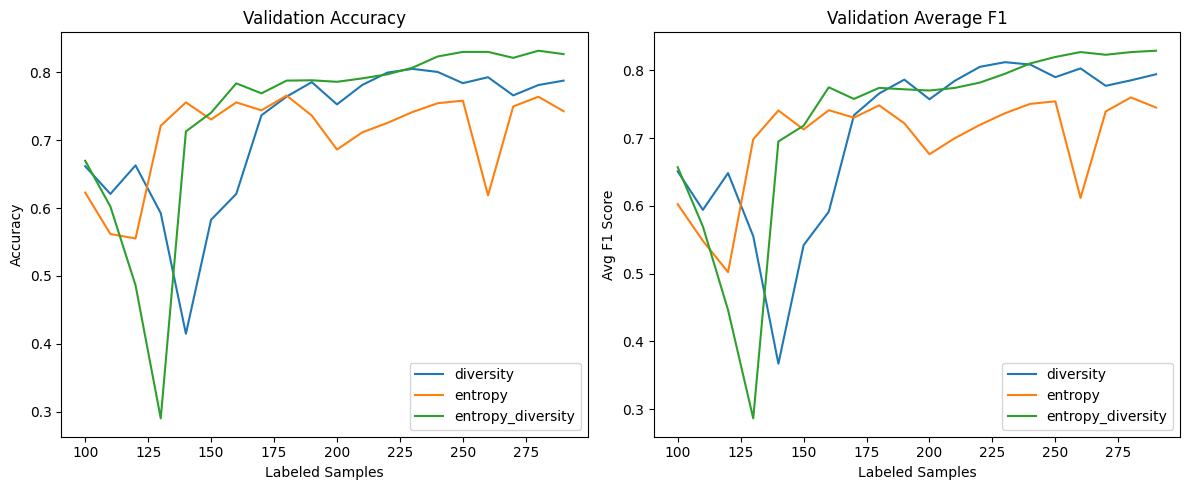

{'diversity': {'strategy': 'diversity', 'samples': [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290], 'epoch_metrics': [[{'train_loss': 3.422454071044922, 'train_acc': 0.24, 'train_avg_f1': 0.2310185185185185, 'val_loss': 1.585578010559082, 'val_acc': 0.5635, 'val_avg_f1': 0.5539334145831664}, {'train_loss': 3.1626516246795653, 'train_acc': 0.3, 'train_avg_f1': 0.29970522597353, 'val_loss': 1.3518029441833497, 'val_acc': 0.5805, 'val_avg_f1': 0.5731012562696696}, {'train_loss': 3.116546964645386, 'train_acc': 0.32, 'train_avg_f1': 0.3156512716261144, 'val_loss': 1.2298821954727173, 'val_acc': 0.62425, 'val_avg_f1': 0.6154324157096366}, {'train_loss': 2.878952827453613, 'train_acc': 0.37, 'train_avg_f1': 0.3442936711038473, 'val_loss': 1.1610089769363403, 'val_acc': 0.65075, 'val_avg_f1': 0.6397282401961161}, {'train_loss': 2.734353141784668, 'train_acc': 0.33, 'train_avg_f1': 0.32550824702723435, 'val_loss': 1.0945750255584716, 'val_ac

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Val Accuracy plot
plt.subplot(1, 2, 1)
for strat, hist in all_histories.items():
    plt.plot(hist["samples"], hist["round_val_acc"], label=strat)
plt.title("Validation Accuracy")
plt.xlabel("Labeled Samples")
plt.ylabel("Accuracy")
plt.legend()

# Val F1 plot
plt.subplot(1, 2, 2)
for strat, hist in all_histories.items():
    plt.plot(hist["samples"], hist["round_val_avg_f1"], label=strat)
plt.title("Validation Average F1")
plt.xlabel("Labeled Samples")
plt.ylabel("Avg F1 Score")
plt.legend()

plt.tight_layout()
plt.show()

print(all_histories)